In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Analyse Exploratoire

In [ ]:
#!pip install keras-tuner --upgrade

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
#import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from sklearn.utils import shuffle
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [3]:
import pathlib
import PIL
import PIL.Image


In [4]:
warnings.filterwarnings('ignore')

### chargement des données

In [ ]:
#import shutil
#shutil.unpack_archive("/content/drive/MyDrive/Openclassrooms/annotation.tar", "/content/drive/MyDrive/Openclassrooms/")

In [ ]:
#!tar -xvzf "/content/drive/MyDrive/Openclassrooms/images.tar"

In [ ]:
#shutil.unpack_archive("/content/drive/MyDrive/Openclassrooms/images.tar", "/content/drive/MyDrive/Openclassrooms/")

In [5]:
# Define path to data
#annotations_dir = '/content/drive/MyDrive/Openclassrooms/Annotation_' 
images_dir = '/content/drive/MyDrive/Openclassrooms/Images_'
# calculer le nombre de classes ( race de chien)
race_list = os.listdir(images_dir)
print("Nombre de races dans le dataset:", (len(race_list)))

Nombre de races dans le dataset: 120


In [6]:
race_list

['n02085620-Chihuahua',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091467-Norwegian_elkhound',
 'n02091831-Saluki',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093991-Irish_terrier',
 'n02094258-Norwich_terrier',
 'n02094433-Yorkshire_terrier',
 'n02095314-wire-haired_fox_terrier',
 'n02095570-Lakeland_terrier',
 'n02095889-Sealyham_terrier',
 'n02096051-Airedale',
 'n02096177-cairn',
 'n02096437-Dandie_Dinmont',
 'n02096585-Boston_bull',
 'n02097047-miniature_schnauzer',
 'n02097130-giant_schnauzer',
 'n02097298-Scotch_terrier',
 'n02097474-Tibetan_terrier',
 'n02097658-s

In [7]:
n_classes = len(os.listdir(images_dir))
n_images = 0
for i in range(n_classes):
    n_images += len(os.listdir(images_dir +"/"+ race_list[i]))
print("Number of images: ", n_images)
print("Number of classes: ", n_classes)

Number of images:  20580
Number of classes:  120


120 races de chien sont donc présentes dans notre jeu de données ==> 120 classes

In [ ]:
#data_dir = pathlib.Path(images_dir)

In [ ]:
#image_count = len(list(data_dir.glob('*/*.jpg')))
#print("le nombre d'images du dataset est : ",image_count)

le nombre d'images du dataset est :  20580


### Analyse de distribution des classes

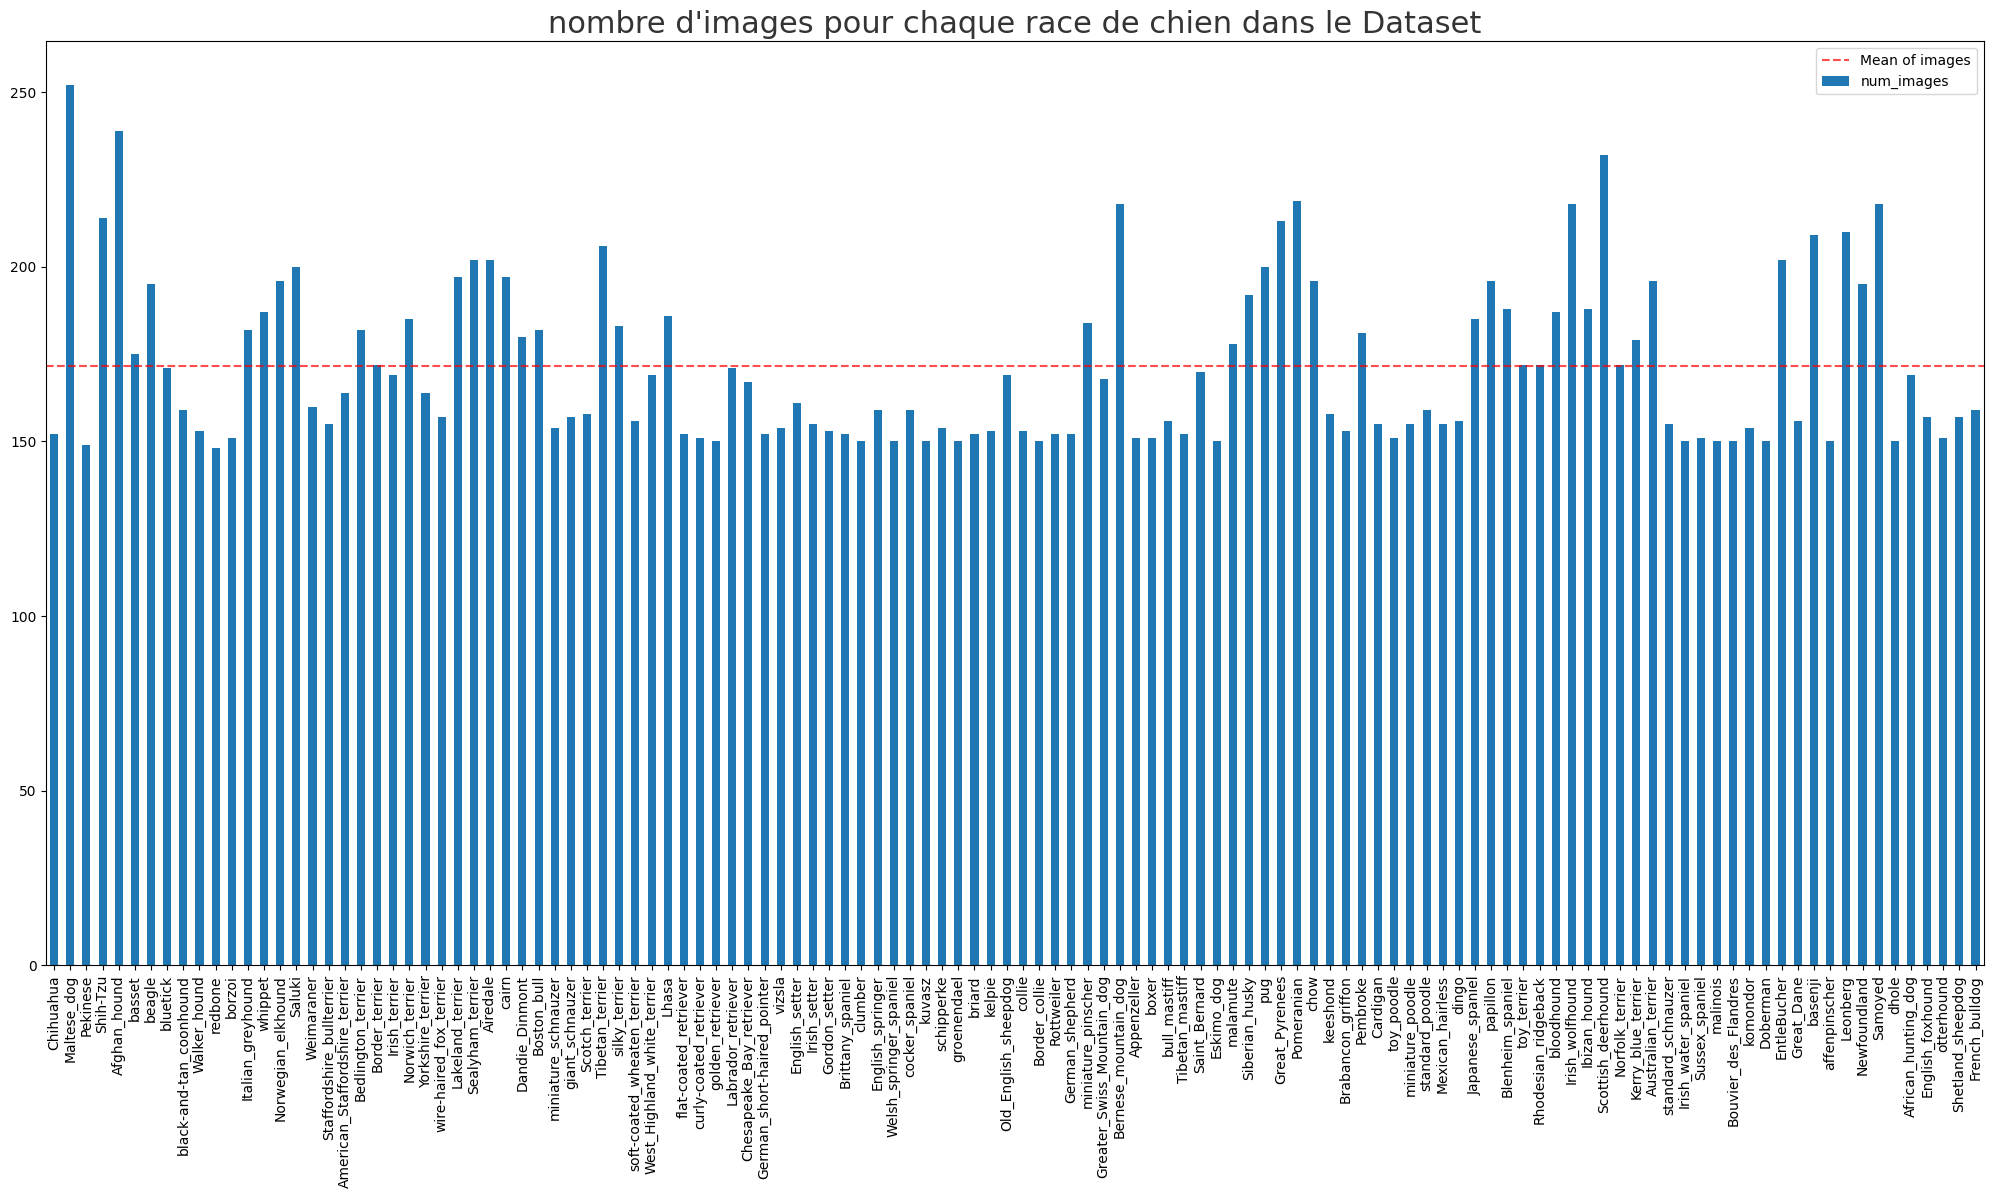

In [8]:
# Count number of pictures for each breed
df_races = pd.DataFrame(
    index=[race.split('-',1)[1]
           for race in race_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in race_list],
    columns=["num_images"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_races.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_races["num_images"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of images")
plt.title("nombre d'images pour chaque race de chien dans le Dataset", color="#343434", fontsize=22)
plt.legend()
plt.show()

In [9]:
df_races.head(10)

,num_images
Chihuahua,152
Maltese_dog,252
Pekinese,149
Shih-Tzu,214
Afghan_hound,239
basset,175
beagle,195
bluetick,171
black-and-tan_coonhound,159
Walker_hound,153


In [10]:
df_races=df_races.reset_index()

In [11]:
df_races.describe()

,num_images
count,120.000000
mean,171.500000
std,23.220898
min,148.000000
25%,152.750000
50%,159.500000
75%,186.250000
max,252.000000


On remarque que les races de chien sont toutes bien alimentées en images. il y a une moyenne de 171 d'image par classe (min = 152 images, max = 252 images).

### Visualisation de quelque images

In [ ]:
images_dir

'/content/drive/MyDrive/Openclassrooms/Images_'

In [ ]:
def show_dir_images(race, n_to_show):
    plt.figure(figsize=(20,20))
    img_dir = '/content/drive/MyDrive/Openclassrooms/Images_/{}/'.format(race)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(int(n_to_show/5+1), 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(race.split('-',1)[1])
    plt.show()


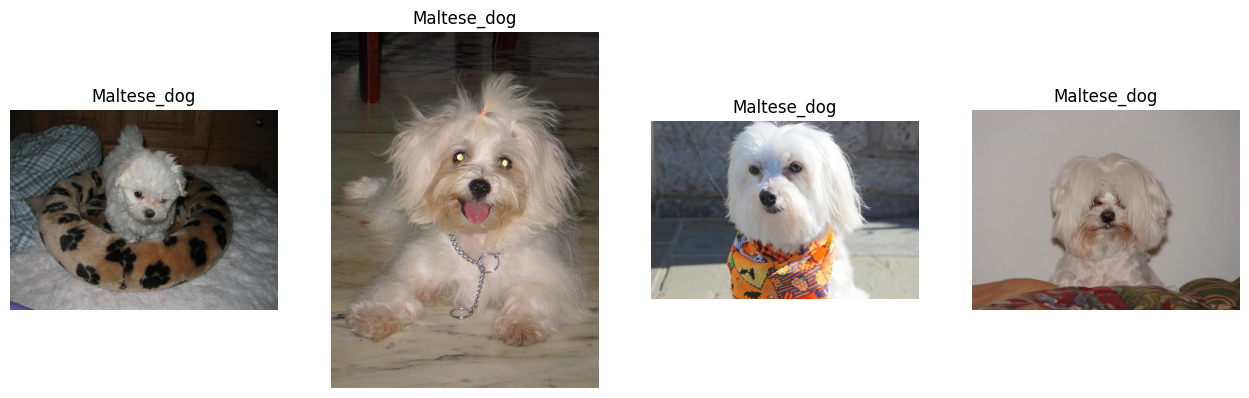

In [ ]:
show_dir_images(race_list[1], 4)


on remarque que les images sont en couleur , et ont des dimensions différentes. 

## selectionner top N classes

On selectionne les N classes les plus populaires: les races plus alimenter en images.

In [12]:
df_races = df_races.sort_values('num_images', ascending=False)

In [13]:
nbr_classes= 20
data = df_races.iloc[:nbr_classes]

In [14]:
data = data.reset_index()
data = data.rename({'index': 'race'}, axis=1) 

In [15]:
data

,level_0,race,num_images
0,1,Maltese_dog,252
1,4,Afghan_hound,239
2,96,Scottish_deerhound,232
3,77,Pomeranian,219
4,66,Bernese_mountain_dog,218
5,94,Irish_wolfhound,218
6,113,Samoyed,218
7,3,Shih-Tzu,214
8,76,Great_Pyrenees,213
9,111,Leonberg,210


In [16]:
top_n_races=data.race.to_list()
top_n_races

['Maltese_dog',
 'Afghan_hound',
 'Scottish_deerhound',
 'Pomeranian',
 'Bernese_mountain_dog',
 'Irish_wolfhound',
 'Samoyed',
 'Shih-Tzu',
 'Great_Pyrenees',
 'Leonberg',
 'basenji',
 'Tibetan_terrier',
 'EntleBucher',
 'Sealyham_terrier',
 'Airedale',
 'Saluki',
 'pug',
 'cairn',
 'Lakeland_terrier',
 'chow']

In [17]:
list_topNraces = []
for race in race_list:
  if race.split('-',1)[1]  in top_n_races:
    list_topNraces.append(race)

In [18]:
list_topNraces

['n02085936-Maltese_dog',
 'n02086240-Shih-Tzu',
 'n02088094-Afghan_hound',
 'n02091831-Saluki',
 'n02095570-Lakeland_terrier',
 'n02095889-Sealyham_terrier',
 'n02096051-Airedale',
 'n02096177-cairn',
 'n02097474-Tibetan_terrier',
 'n02107683-Bernese_mountain_dog',
 'n02110958-pug',
 'n02111500-Great_Pyrenees',
 'n02112018-Pomeranian',
 'n02112137-chow',
 'n02090721-Irish_wolfhound',
 'n02092002-Scottish_deerhound',
 'n02108000-EntleBucher',
 'n02110806-basenji',
 'n02111129-Leonberg',
 'n02111889-Samoyed']

# model 1 CNN from scratch (AlexNet Basic)

## preprocessing step

On va implémenter dans cette partie une architecture CNN simple : AlexNet. donc on va redimenssioner nos images à 227 * 227 * 3. 

In [19]:
import keras.utils as image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
img_size = 227

def preprocesse_images_CNN(dir,img_size):
    labels = []
    img_list=[]
    for index, race in enumerate(dir):
        for image_name in os.listdir(images_dir+"/"+race):
            # Read image
            img = load_img(images_dir+"/"+race+"/"+image_name)
            # Resize image
            dim = (img_size, img_size)
            img = img.resize(dim)           
            # Convert modified img 2 array
            img_array = img_to_array(img)            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(race.split("-")[1])
    return img_list , labels

In [45]:
# Execute preprocessor on selection
start_time = timeit.default_timer()
# X are array images and y are labels .
X,y = preprocesse_images_CNN(list_topNraces,img_size)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time

print("-" * 50)
print(" le temps d'excution pour le pré-traitement:")
print("-" * 50)
print("nombre d'image traité: {}"\
     .format(len(y)))
print("Shape des images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
 le temps d'excution pour le pré-traitement:
--------------------------------------------------
nombre d'image traité: 4244
Shape des images np.array : (4244, 227, 227, 3)
Total time : 32.31s


In [21]:
X.shape

(4244, 227, 227, 3)

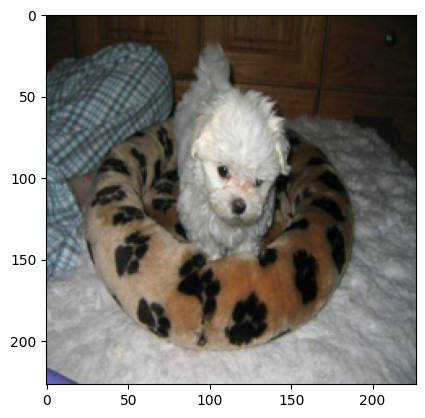

In [ ]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[0]))

Nous avons créé des listes de tableaux Numpy regroupant les images sous format numériques.
Pour entrainer notre premier modèle, nous devons dans un premier temps mélanger les images car actuellement, toutes les photos d'une même race se suivent.

In [46]:
X , y = shuffle(X, y, random_state = 1)

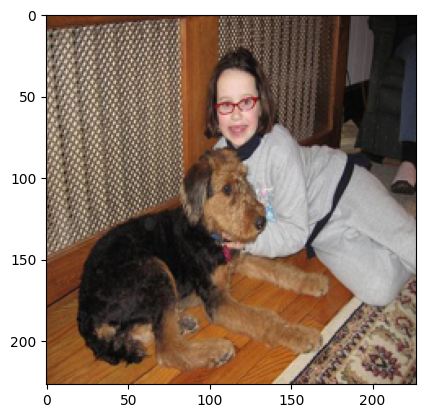

In [ ]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[0]))

maintenent il faut modifier les types de nos données X et y. 

y pour le moment sont des données textuelle. Nous allons donc utiliser un simple LabelEncoder pour les convertir.

In [47]:
# Change X type 
X = X.astype(np.float32) / 255 # normalization 
#X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [24]:
# Verifie encoder created classes
print(encoder.classes_)

['Afghan_hound' 'Airedale' 'Bernese_mountain_dog' 'EntleBucher'
 'Great_Pyrenees' 'Irish_wolfhound' 'Lakeland_terrier' 'Leonberg'
 'Maltese_dog' 'Pomeranian' 'Saluki' 'Samoyed' 'Scottish_deerhound'
 'Sealyham_terrier' 'Shih' 'Tibetan_terrier' 'basenji' 'cairn' 'chow'
 'pug']


## Train_test_split

on va crée un set de training , validation et test  avec 'train_test_split'.

In [48]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("la tille du set de train = ",x_train.shape[0])
print("la taille du set de test = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
la tille du set de train =  3395
la taille du set de test =  849


In [32]:
x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

## data augmentation

La data augmentation est une technique utilisée dans l'apprentissage automatique et la vision par ordinateur pour augmenter la taille et la variété d'un ensemble de données d'entraînement. Elle consiste à appliquer des transformations aléatoires ou contrôlées aux données existantes, créant ainsi de nouvelles observations similaires mais avec des variations mineures. L'objectif est d'améliorer la capacité d'un modèle à généraliser et à traiter de nouvelles données en lui fournissant des exemples supplémentaires et plus variés. Cela contribue à éviter le surapprentissage et permet au modèle d'apprendre à reconnaître des motifs plus robustes et généraux. 


 Pour cela, Keras mets à disposition la méthode ImageDataGenerator qui permet de faire à la fois du mirroring, de la rotation, des zoom ... et ce de manière aléatoire.


 La méthode de Data Augmentation nous permet d'obtenir des images avec différents zoom, des effets mirroir et des rotations qui vont donc augmenter notre base d'images significativement et efficacement 

In [50]:
batch_size = 16

# Validation set is define here
train_datagen = ImageDataGenerator(
   # rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  #set valisation split
    )

#For test just rescale
test_datagen = ImageDataGenerator()#rescale=1./255)


train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, subset='training')
validation_generator = train_datagen.flow( x_train, y_train, batch_size = batch_size,  subset='validation')


## modèle 1 CNN (from sratch)

Nous allons ici initialiser un premier modèle de réseau de neurones à convolution en imbriquant plusieurs couches :



*   **Couches de convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution.

*   **Couches de Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.


*   **Couches Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.


Nous allons tester une architecture simple avec 5 couches de convolution.








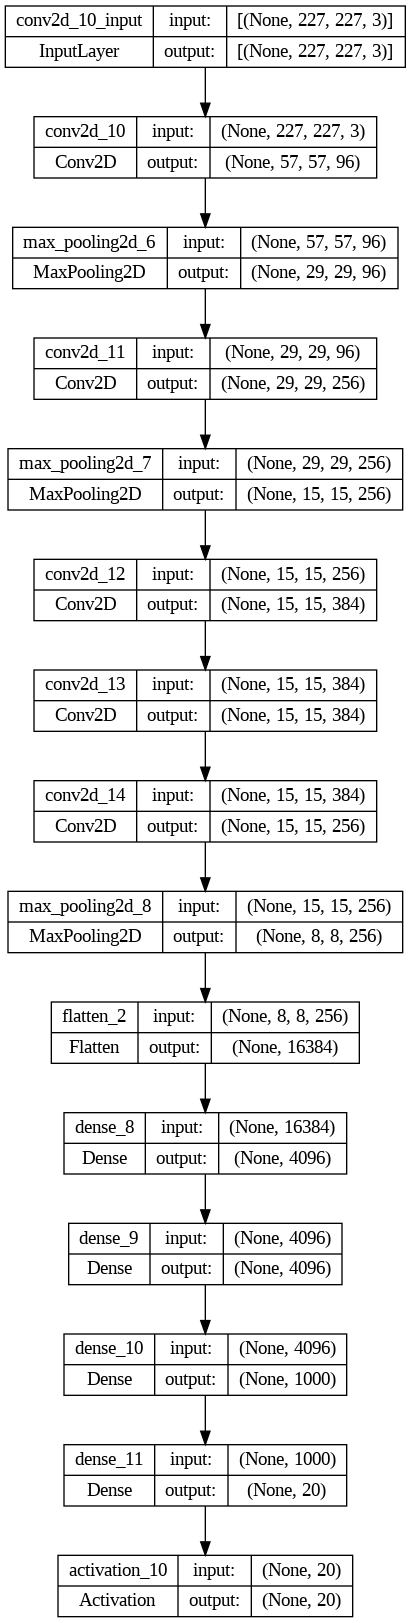

In [51]:
# L'architectue du réseau de neurone CNN 
model = Sequential()

# 1st Convolution layer
model.add(Conv2D(input_shape=(227,227,3), filters=96 ,kernel_size=(11,11), strides=(4,4), padding='same')) 
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


# 2nd convolution layer
model.add(Conv2D(filters=256,  kernel_size=(5,5), padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 3rd convolution layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))


# 4th convolution layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))


# 5th convolution layer
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


# Fully connected layers
model.add(Flatten())  # ====> features 
model.add(Dense(4096, input_shape=(227,227,3,)))


# 2nd fully connected layer
model.add(Dense(4096))


#3rd fully connected layer
model.add(Dense(1000))
#output layer
model.add(Dense(nbr_classes))
model.add(Activation('softmax'))

plot_model(model, show_shapes=True, show_layer_names=True)

In [52]:
# Compiler le modèle CNN 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [53]:
#les callbacks
#checkpoint_filepath = '/content/drive/MyDrive/Openclassrooms/Checkpoint/checkpoint_cnn1-{val_accuracy:.02f}.h5'
#save_model= ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5) # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  

### fit without data augmentation

In [42]:
start_time1 = timeit.default_timer()
epochs=30
history_basic = model.fit(
    x_train_,y_train_,
    validation_data=(x_val,y_val),
    validation_split=0.2,
    epochs=epochs,
    batch_size=16,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time1 = timeit.default_timer() - start_time1
print("Total time : {:.2f}s".format(preprocess_time1))

Epoch 1/30
170/170 [==============================] - 7s 25ms/step - loss: 2.8849 - accuracy: 0.1418 - val_loss: 2.8141 - val_accuracy: 0.1576 - lr: 1.0000e-04
Epoch 2/30
170/170 [==============================] - 3s 20ms/step - loss: 2.5563 - accuracy: 0.2191 - val_loss: 2.5116 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 3/30
170/170 [==============================] - 3s 20ms/step - loss: 2.3345 - accuracy: 0.2846 - val_loss: 2.6359 - val_accuracy: 0.2018 - lr: 1.0000e-04
Epoch 4/30
170/170 [==============================] - 3s 20ms/step - loss: 2.0367 - accuracy: 0.3855 - val_loss: 2.6517 - val_accuracy: 0.2371 - lr: 1.0000e-04
Epoch 5/30
170/170 [==============================] - 3s 20ms/step - loss: 1.5596 - accuracy: 0.5239 - val_loss: 3.2469 - val_accuracy: 0.1973 - lr: 1.0000e-04
Epoch 6/30
170/170 [==============================] - 3s 20ms/step - loss: 1.0594 - accuracy: 0.6708 - val_loss: 3.9294 - val_accuracy: 0.1944 - lr: 1.0000e-04
Epoch 7/30
170/170 [====================

In [37]:
def plot_history_scores(dict_history):
       
        acc = dict_history.history['accuracy']
        val_acc = dict_history.history['val_accuracy']
        loss = dict_history.history['loss']
        val_loss = dict_history.history['val_loss']

        epochs_x = range(len(acc))

        plt.plot(epochs_x, acc, 'bo', label='Training acc')
        plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs_x, loss, 'bo', label='Training loss')
        plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

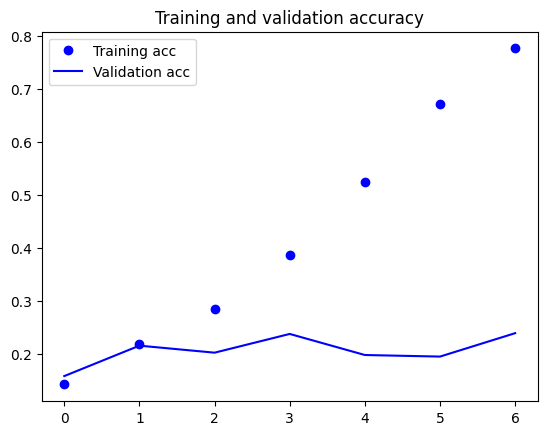

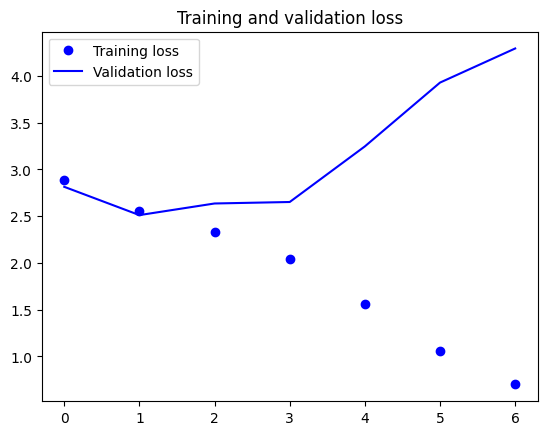

In [43]:
plot_history_scores( dict_history = history_basic)

### fit with data augmentation

In [54]:
# train with data augmentation 

start_time1 = timeit.default_timer()
epochs=20
history = model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps = validation_generator.n // batch_size,    
    epochs=epochs,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time1 = timeit.default_timer() - start_time1
print("Total time : {:.2f}s".format(preprocess_time1))

Epoch 1/20
169/169 [==============================] - 41s 225ms/step - loss: 2.9939 - accuracy: 0.0963 - val_loss: 2.8937 - val_accuracy: 0.1131 - lr: 1.0000e-04
Epoch 2/20
169/169 [==============================] - 35s 207ms/step - loss: 2.8846 - accuracy: 0.1148 - val_loss: 3.0164 - val_accuracy: 0.0848 - lr: 1.0000e-04
Epoch 3/20
169/169 [==============================] - 35s 205ms/step - loss: 2.8007 - accuracy: 0.1367 - val_loss: 2.7675 - val_accuracy: 0.1295 - lr: 1.0000e-04
Epoch 4/20
169/169 [==============================] - 35s 206ms/step - loss: 2.7748 - accuracy: 0.1422 - val_loss: 2.7758 - val_accuracy: 0.1414 - lr: 1.0000e-04
Epoch 5/20
169/169 [==============================] - 35s 204ms/step - loss: 2.7619 - accuracy: 0.1426 - val_loss: 2.6875 - val_accuracy: 0.1696 - lr: 1.0000e-04
Epoch 6/20
169/169 [==============================] - 36s 212ms/step - loss: 2.7296 - accuracy: 0.1519 - val_loss: 2.6616 - val_accuracy: 0.1607 - lr: 1.0000e-04
Epoch 7/20
169/169 [========

In [ ]:
# train with data augmentation 

start_time1 = timeit.default_timer()
epochs=30
history = model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps = validation_generator.n // batch_size,    
    epochs=epochs,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time1 = timeit.default_timer() - start_time1
print("Total time : {:.2f}s".format(preprocess_time1))

Epoch 1/30
169/169 [==============================] - 41s 221ms/step - loss: 3.0255 - accuracy: 0.0981 - val_loss: 2.9248 - val_accuracy: 0.1071 - lr: 1.0000e-04
Epoch 2/30
169/169 [==============================] - 37s 220ms/step - loss: 2.8486 - accuracy: 0.1189 - val_loss: 3.0351 - val_accuracy: 0.0818 - lr: 1.0000e-04
Epoch 3/30
169/169 [==============================] - 38s 223ms/step - loss: 2.8210 - accuracy: 0.1367 - val_loss: 2.8057 - val_accuracy: 0.1280 - lr: 1.0000e-04
Epoch 4/30
169/169 [==============================] - 37s 222ms/step - loss: 2.7626 - accuracy: 0.1507 - val_loss: 2.7237 - val_accuracy: 0.1815 - lr: 1.0000e-04
Epoch 5/30
169/169 [==============================] - 38s 224ms/step - loss: 2.7589 - accuracy: 0.1556 - val_loss: 2.6779 - val_accuracy: 0.1920 - lr: 1.0000e-04
Epoch 6/30
169/169 [==============================] - 37s 221ms/step - loss: 2.7391 - accuracy: 0.1615 - val_loss: 2.6219 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 7/30
169/169 [========

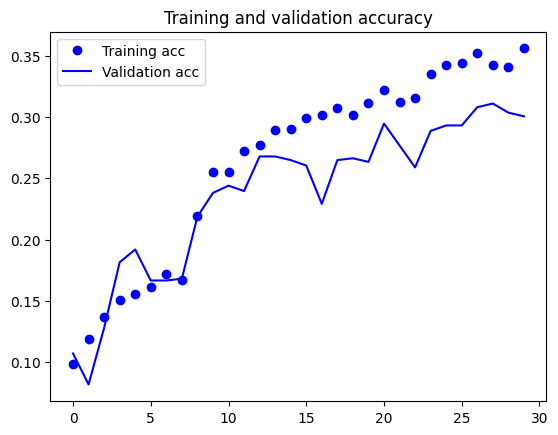

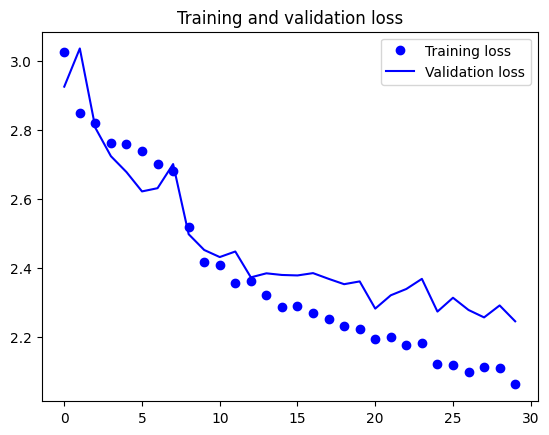

In [ ]:
plot_history_scores( dict_history = history)

In [ ]:
def get_images(race, n_images_to_get,image_size):
    image_test =[]
    img_dir = '/content/drive/MyDrive/Openclassrooms/Images_/{}/'.format(race)
    images = os.listdir(img_dir)[:n_images_to_get]
    for i in range(n_images_to_get):
        img = load_img(img_dir + images[i])
        img = img.resize([image_size,image_size])
        img_numpy_array = img_to_array(img)
        image_test.append(img_numpy_array)

    return images ,image_test


In [ ]:
race_list[0]

'n02085620-Chihuahua'

In [ ]:
# function of test
list_images_test,images_test = get_images(race_list[0], 2, 227) # image_size=227
list_images_test

['n02085620_11238.jpg', 'n02085620_12718.jpg']

In [ ]:
def prediction_test_image(model,image):
  prediction=model.predict(np.expand_dims(image,axis=0))
  classes_x=np.argmax(prediction,axis=1)
  output_class = encoder.classes_[classes_x].tolist()
  return output_class

In [ ]:
prediction_test_image(model,images_test[0])

1/1 [==============================] - 0s 117ms/step


['Tibetan_terrier']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model1 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model1)

27/27 [==============================] - 0s 13ms/step
accuracy of test =  0.2037691401648999


In [ ]:

acc_score_model1 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model1)


accuracy of test =  0.2037691401648999


In [ ]:
model_size = model.count_params()

In [ ]:
model_size

91758492

In [ ]:
df_results = pd.DataFrame(columns=['model','learning_rate' ,'accuracy_test', 'temps','model_size'])

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size


In [ ]:
df_results = df_results.append({'model': 'basic_CNN_from_scratch 1','learning_rate':1e-4 ,'accuracy_test': acc_score_model1, 'temps': '823.03', 'model_size': model_size,'batchsize':'16'}, ignore_index=True)


In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,basic_CNN_from_scratch 1,0.0001,0.380448,823.03,91758492,16


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', mode='a', header=False)

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,basic_CNN_from_scratch 1,0.0001,0.380448,823.03,91758492,16


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Openclassrooms/resultas.csv" ,error_bad_lines=False)

Skipping line 11: expected 6 fields, saw 7
Skipping line 12: expected 6 fields, saw 7
Skipping line 13: expected 6 fields, saw 7
Skipping line 14: expected 6 fields, saw 7
Skipping line 15: expected 6 fields, saw 7



In [ ]:
update_df = df.drop([7])
update_df

,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,efficientnetV2B0,0.0001,0.963486,925.396086,6.252388e+06,16.0
1,ConvNextTiny,0.0001,0.982332,1467.736406,2.802213e+07,16.0
2,MobilNetV3,0.0001,0.871614,985.952251,1.091972e+06,16.0
3,efficientnetV2B0,0.001,0.963486,1403.241162,6.252388e+06,16.0
4,efficientnetV2B0,0.01,0.957597,725.197869,6.252388e+06,16.0
5,efficientnetV2B0,0.0001,0.965842,1210.955557,6.252388e+06,8.0
6,0,basic_CNN_from_scratch,0.000100,0.346290,3.517741e+02,91758492.0
8,CNN AlexNet improved,0.0001,0.343934,1022.495579,9.180076e+07,16.0


In [ ]:
update_df.loc[6, 'model'] = 'basic_CNN_from_scratch'
update_df.loc[6, 'learning_rate'] = '0.0001'
update_df.loc[6, 'accuracy_test'] = '0.203769'
update_df.loc[6, 'batchsize'] = '16.0'
update_df.loc[6, 'temps'] = '1138.55'
update_df.loc[6, 'model_size'] = '91758492'


update_df.loc[8, 'accuracy_test'] = '0.346289'

update_df.loc[8, 'temps'] = '912.35s'
update_df.loc[8, 'model_size'] = '91800764'
update_df

,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388.0,16.0
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132.0,16.0
2,MobilNetV3,0.0001,0.871614,985.952251,1091972.0,16.0
3,efficientnetV2B0,0.001,0.963486,1403.241162,6252388.0,16.0
4,efficientnetV2B0,0.01,0.957597,725.197869,6252388.0,16.0
5,efficientnetV2B0,0.0001,0.965842,1210.955557,6252388.0,8.0
6,basic_CNN_from_scratch,0.0001,0.203769,1138.55,91758492,16.0
8,CNN AlexNet improved,0.0001,0.346289,912.35s,91800764,16.0


On voit que sur ce modèle CNN from scratch les métriques ne sont pas bonnes.  Ce modèle serve de baseline. 



# model 2 (AlexNet improved)


Maintenent on va amélirer l'architecture du modèle CNN from scratch en rajoutant : les fonction : BatchNormalization() , Activation('relu') entre la couche Conv et pooling . 

en rajoutant la fonction Dropout() dans la fully connnected layer pour éviter le surapprentissage. 

* **BatchNormalization()** : La fonction BatchNormalization() est une technique utilisée dans les réseaux de neurones pour normaliser les activations des couches. Elle a pour objectif d'accélérer l'entraînement du modèle, de faciliter la convergence et de stabiliser les poids du réseau. La normalisation par lots (batch normalization) est appliquée à une couche en calculant la moyenne et l'écart-type des activations pour chaque mini-lot (batch) pendant l'entraînement. Ces statistiques sont utilisées pour normaliser les activations en soustrayant la moyenne et en divisant par l'écart-type.
* **Activation('relu')** : est une fonction d'activation utilisée dans les réseaux de neurones, où "relu" signifie Rectified Linear Unit. C'est l'une des fonctions d'activation les plus couramment utilisées dans les réseaux de neurones en raison de sa simplicité et de ses performances efficaces.La fonction d'activation ReLU est définie comme suit : ReLU(x) = max(0, x). 
* **Dropout** : La fonction layers.Dropout est une couche de régularisation utilisée dans les réseaux de neurones pour prévenir le surapprentissage (overfitting). Le surapprentissage se produit lorsque le modèle mémorise trop bien les exemples d'entraînement spécifiques et ne généralise pas correctement aux nouvelles données. La couche Dropout est utilisée pour désactiver aléatoirement un certain pourcentage de neurones d'entrée pendant la phase d'entraînement. Cela signifie que ces neurones ne contribueront pas à la propagation avant et à la rétropropagation du gradient pendant cette itération d'entraînement spécifique.


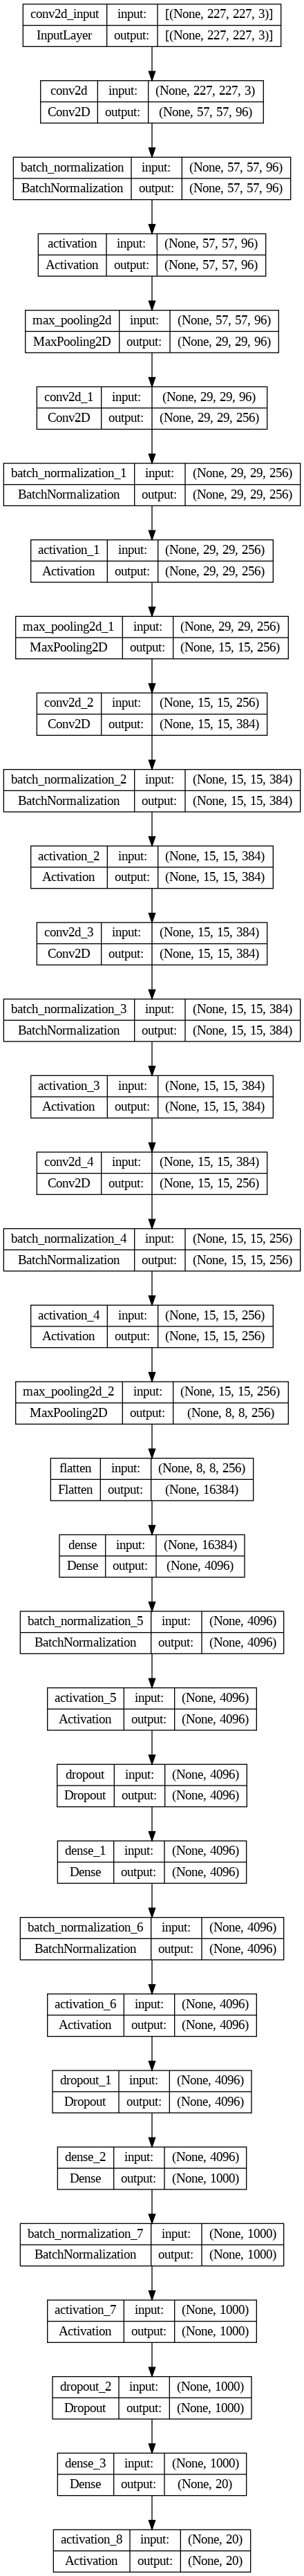

In [33]:
K.clear_session()

model2 = Sequential()

# 1st Convolution layer
model2.add(Conv2D(input_shape=(227,227,3), filters=96 ,kernel_size=(11,11), strides=(4,4), padding='same')) 
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


# 2nd convolution layer
model2.add(Conv2D(filters=256,  kernel_size=(5,5), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 3rd convolution layer
model2.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

# 4th convolution layer
model2.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

# 5th convolution layer
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


# Fully connected layers
model2.add(Flatten())  # ====> features 

# 1st fully connected layer
model2.add(Dense(4096, input_shape=(227,227,3,)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))


# 2nd fully connected layer
model2.add(Dense(4096))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))  # pour éviter le sur-apprentissage 

#3rd fully connected layer
model2.add(Dense(1000))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
#output layer
model2.add(Dense(nbr_classes))
model2.add(Activation('softmax'))

plot_model(model2, show_shapes=True, show_layer_names=True)

In [34]:
# Compiler le modèle CNN
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### fit without data augmentation

In [35]:
#checkpoint_filepath_2 = '/content/drive/MyDrive/Openclassrooms/Checkpoint/checkpoint_cnn2-{val_accuracy:.02f}.hdf5'
#save_model2= ModelCheckpoint(checkpoint_filepath_2, save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5) # This callback will stop the training when there is no improvement in the loss for five consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs=30

In [36]:
start_time1 = timeit.default_timer()
epochs=30
history_basic_2 = model2.fit(
    x_train_,y_train_,
    validation_data=(x_val,y_val),
   # validation_split=0.2,
    epochs=epochs,
    batch_size=16,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time1 = timeit.default_timer() - start_time1
print("Total time : {:.2f}s".format(preprocess_time1))

Epoch 1/30
170/170 [==============================] - 11s 31ms/step - loss: 3.0342 - accuracy: 0.1517 - val_loss: 4.4017 - val_accuracy: 0.0501 - lr: 1.0000e-04
Epoch 2/30
170/170 [==============================] - 4s 24ms/step - loss: 2.5281 - accuracy: 0.2459 - val_loss: 4.7921 - val_accuracy: 0.0604 - lr: 1.0000e-04
Epoch 3/30
170/170 [==============================] - 4s 23ms/step - loss: 2.0915 - accuracy: 0.3535 - val_loss: 3.2157 - val_accuracy: 0.1605 - lr: 1.0000e-04
Epoch 4/30
170/170 [==============================] - 4s 22ms/step - loss: 1.6898 - accuracy: 0.4797 - val_loss: 2.6574 - val_accuracy: 0.2459 - lr: 1.0000e-04
Epoch 5/30
170/170 [==============================] - 4s 22ms/step - loss: 1.1913 - accuracy: 0.6329 - val_loss: 3.4899 - val_accuracy: 0.2077 - lr: 1.0000e-04
Epoch 6/30
170/170 [==============================] - 4s 23ms/step - loss: 0.7539 - accuracy: 0.7743 - val_loss: 3.1709 - val_accuracy: 0.2489 - lr: 1.0000e-04
Epoch 7/30
170/170 [===================

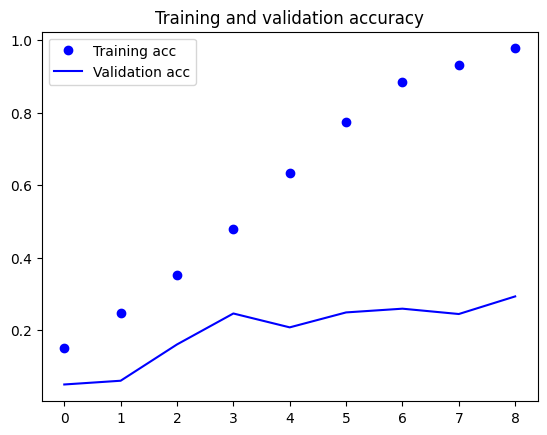

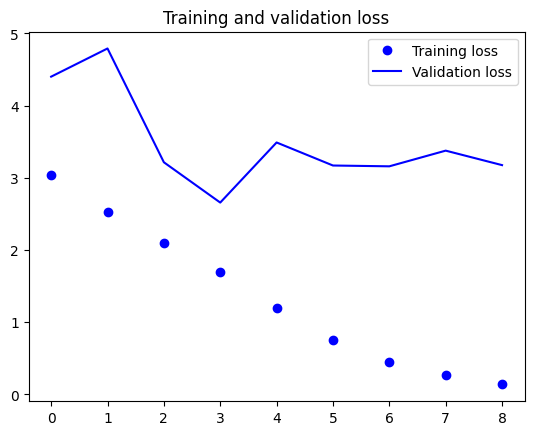

In [38]:
plot_history_scores( dict_history = history_basic_2)

### fit with data augmentation

In [ ]:
#checkpoint_filepath_2 = '/content/drive/MyDrive/Openclassrooms/Checkpoint/checkpoint_cnn2-{val_accuracy:.02f}.hdf5'
#save_model2= ModelCheckpoint(checkpoint_filepath_2, save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5) # This callback will stop the training when there is no improvement in the loss for five consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs=30

In [ ]:
# with data augmentation
start_time2 = timeit.default_timer()
history2 = model2.fit(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps = validation_generator.n // batch_size,    
    epochs=epochs,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time2 = timeit.default_timer() - start_time2
print("Total time : {:.2f}s".format(preprocess_time2))

Epoch 1/30
169/169 [==============================] - 44s 222ms/step - loss: 3.2681 - accuracy: 0.1063 - val_loss: 4.0644 - val_accuracy: 0.0521 - lr: 1.0000e-04
Epoch 2/30
169/169 [==============================] - 38s 223ms/step - loss: 2.9632 - accuracy: 0.1426 - val_loss: 5.1732 - val_accuracy: 0.0536 - lr: 1.0000e-04
Epoch 3/30
169/169 [==============================] - 37s 217ms/step - loss: 2.8288 - accuracy: 0.1633 - val_loss: 3.7264 - val_accuracy: 0.0908 - lr: 1.0000e-04
Epoch 4/30
169/169 [==============================] - 37s 218ms/step - loss: 2.7314 - accuracy: 0.1815 - val_loss: 2.8608 - val_accuracy: 0.1682 - lr: 1.0000e-04
Epoch 5/30
169/169 [==============================] - 37s 222ms/step - loss: 2.6634 - accuracy: 0.1981 - val_loss: 2.8030 - val_accuracy: 0.1741 - lr: 1.0000e-04
Epoch 6/30
169/169 [==============================] - 40s 239ms/step - loss: 2.6126 - accuracy: 0.2004 - val_loss: 3.4828 - val_accuracy: 0.1190 - lr: 1.0000e-04
Epoch 7/30
169/169 [========

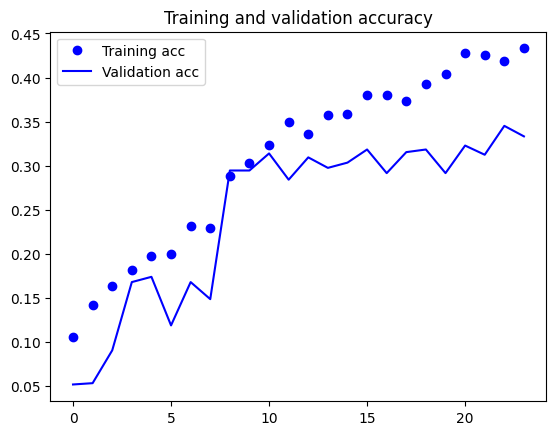

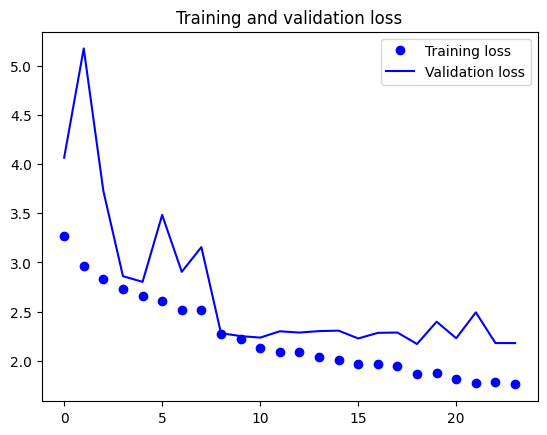

In [ ]:
plot_history_scores( dict_history = history2)

In [ ]:
race_list[0]

'n02085620-Chihuahua'

In [ ]:
prediction_test_image(model2,images_test[0])

1/1 [==============================] - 0s 23ms/step


['pug']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model2 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model2)

27/27 [==============================] - 0s 14ms/step
accuracy of test =  0.3462897526501767


In [ ]:
model_size2 = model2.count_params()

In [ ]:
model_size2

91800764

In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  
df_results = df_results.append({'model': 'CNN AlexNet improved','learning_rate':1e-4, 'accuracy_test': acc_score_model2, 'temps': preprocess_time2, 'model_size': model_size2,'batchsize': 16}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

ParserError: ignored

# Transfer learning


EfficientNetV2 B0 , convnext et mobilnetV3 nécessitent des images en entrée de taille 224 * 224 * 3, donc nous devons adapter nos images en conséquence pour qu'elles correspondent aux exigences des modèles qu'on va entrainer.

In [ ]:
# Execute preprocessor on selection
start_time3_preprocess = timeit.default_timer()
img_size = 224
X,y = preprocesse_images_CNN(list_topNraces,img_size)  # on refait le pre processing des images car les X sont de dim 227*227 ( par rappor à AlexNet) et maintenent on a besoin de dim 244*224. 
X = np.array(X)
y = np.array(y)
X , y = shuffle(X, y, random_state = 1)
X = X.astype(np.float32)  
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
preprocess_time_3_1 = timeit.default_timer() - start_time3_preprocess
print("Total time : {:.2f}s".format(preprocess_time_3_1))

Total time : 79.12s


In [ ]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("la tille du set de train = ",x_train.shape[0])
print("la taille du set de test = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
la tille du set de train =  3395
la taille du set de test =  849


## model 3 (efficientnetV2 b0)

In [ ]:
batch_size = 16

# Validation set is define here
train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2, #set valisation split
                                   preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
                                    )

#For test just rescale
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, subset='training')
validation_generator = train_datagen.flow( x_train, y_train, batch_size = batch_size,  subset='validation')

Il est également nécessaire de modifier les générateurs pour y intégrer le **preprocess_input efficientnet_v2** recommandé par Keras :

EfficientNetV2 est une famille de modèles de réseaux neuronaux convolutifs (CNN) qui constitue une extension de l'architecture EfficientNet originale. EfficientNet a été conçu pour obtenir des modèles performants et efficaces en termes de puissance de calcul et de mémoire.

EfficientNetV2 B0 est le plus petit modèle de la famille EfficientNetV2. Il est conçu pour être léger et rapide, ce qui en fait un choix approprié pour des ressources informatiques limitées ou des scénarios où l'utilisation d'un modèle plus petit est préférable.



*   EfficientNetV2 utilise un facteur de mise à l'échelle qui détermine la taille globale du modèle. Le facteur de mise à l'échelle contrôle la profondeur, la largeur et la résolution des modèles EfficientNetV2. B0 est le modèle avec le facteur de mise à l'échelle le plus petit. 
*   EfficientNetV2 B0 intègre des techniques de régularisation telles que la normalisation par lots (batch normalization), la régularisation L2 et le dropout pour réduire le surapprentissage (overfitting) et améliorer la généralisation du modèle.
*     Bien qu'EfficientNetV2 B0 soit plus petit en taille et en complexité que les autres modèles de la famille EfficientNet, il peut toujours fournir une performance raisonnablement bonne sur des tâches de classification d'images tout en étant plus rapide à entraîner et à exécuter.



In [ ]:
K.clear_session()



Chargeons le modèle de base pré-entrainé de Keras mais sans les couches fully-connected. Nous allons ajouter notre propre classifier final.

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# importation du modèle  EfficientNetV2B0 pré-entrainer
efficient_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# Gel des poids du modèle pré-entraîné pour éviter qu'ils ne soient mis à jour lors de l'entraînement
efficient_model.trainable = False

In [ ]:
# ajouter le nouveau classifieur 
xef = GlobalAveragePooling2D()(efficient_model.output)
xef = Dense(256, activation='relu')(xef)
xef = tf.keras.layers.Dropout(0.2)(xef)
output = Dense(nbr_classes, activation='softmax')(xef)  

In [ ]:
model3_lr1e4 = Model(inputs=efficient_model.input, outputs=output)

In [ ]:
lr = 1e-4

In [ ]:
model3_lr1e4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

In [ ]:
model3_lr1e4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

maintenent on va faire un fit avec data augmentation en relancant le modèle et la compilation 

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs = 30 

In [ ]:
# traning with data augmentation 
start_time3 = timeit.default_timer()
history3= model3_lr1e4.fit( train_generator,
                      steps_per_epoch= train_generator.n // batch_size,
                      validation_data=validation_generator,
                      validation_steps = validation_generator.n // batch_size,    
                      epochs=epochs,
                      callbacks = [lrr,early_stop],
                      verbose=1)
preprocess_time3 = timeit.default_timer() - start_time3
print("Total time : {:.2f}s".format(preprocess_time3))

Epoch 1/30
169/169 [==============================] - 60s 261ms/step - loss: 1.8967 - accuracy: 0.6141 - val_loss: 0.8853 - val_accuracy: 0.8810 - lr: 1.0000e-04
Epoch 2/30
169/169 [==============================] - 43s 255ms/step - loss: 0.6567 - accuracy: 0.8778 - val_loss: 0.4157 - val_accuracy: 0.9107 - lr: 1.0000e-04
Epoch 3/30
169/169 [==============================] - 41s 242ms/step - loss: 0.4096 - accuracy: 0.9004 - val_loss: 0.3024 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 4/30
169/169 [==============================] - 43s 254ms/step - loss: 0.3312 - accuracy: 0.9104 - val_loss: 0.2651 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 5/30
169/169 [==============================] - 41s 244ms/step - loss: 0.2828 - accuracy: 0.9189 - val_loss: 0.2458 - val_accuracy: 0.9182 - lr: 1.0000e-04
Epoch 6/30
169/169 [==============================] - 43s 252ms/step - loss: 0.2585 - accuracy: 0.9226 - val_loss: 0.2392 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 7/30
169/169 [========

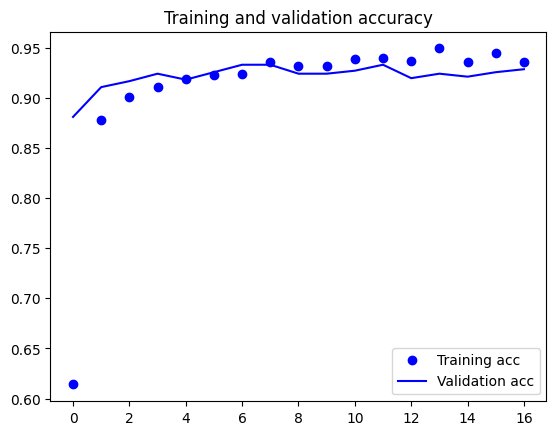

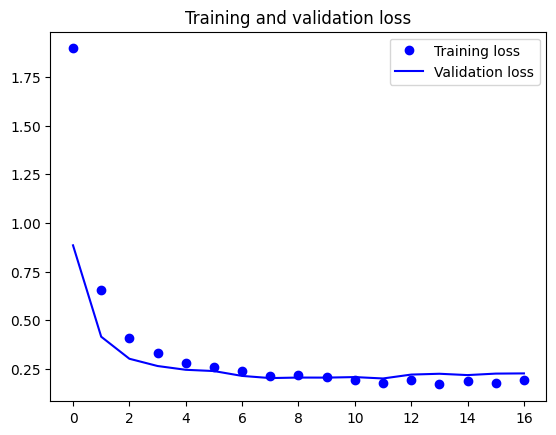

In [ ]:
plot_history_scores( dict_history = history3)

In [ ]:
race_list[1]

'n02085936-Maltese_dog'

In [ ]:
list_images_test,images_test = get_images(race_list[1], 2, 224) # image_size=227 ### traitement comme apprentissage . 
list_images_test

['n02085936_10307.jpg', 'n02085936_10297.jpg']

In [ ]:
prediction_test_image(model3_lr1e4,images_test[0])

1/1 [==============================] - 2s 2s/step


['Maltese_dog']

In [ ]:
prediction_test_image(model3_lr1e4,images_test[1])

1/1 [==============================] - 0s 33ms/step


['Maltese_dog']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model3_lr1e4.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model3 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model3)

27/27 [==============================] - 3s 75ms/step
accuracy of test =  0.9634864546525324


In [ ]:
model_summary3_1e4 = model3_lr1e4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

In [ ]:
total_params_3_1e4 = model3_lr1e4.count_params()


In [ ]:
print('Total parameters:', total_params_3_1e4)

Total parameters: 6252388


In [ ]:
if not os.path.exists('/content/drive/MyDrive/Openclassrooms/resultas.csv'):
    # Create a new DataFrame or use an existing one
    data = {'model': 'efficientnetV2B0',
            'learning_rate': lr,
            'accuracy_test':acc_score_model3,
            'temps':preprocess_time3,
            'model_size':total_params_3_1e4}
    df_results = pd.DataFrame(data,index=[0])
else : 

    df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  

    df_results = df_results.append({'model': 'efficientnetV2B0','learning_rate': lr, 'accuracy_test': acc_score_model3, 'temps': preprocess_time3, 'model_size': total_params_3_1e4}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388


In [ ]:
# Sauvegarder le modèle
#model3.save('/content/drive/MyDrive/Openclassrooms/model_3_efficientnet_acc_test_083')

In [ ]:
# Charger le modèle sauvegardé
#model3 = tf.keras.models.load_model('/content/drive/MyDrive/Openclassrooms/model_3_efficientnet_acc_test_083')


## model 4 (convnext tiny)

Le modèle "ConvNetX Tiny" est une variante du réseau de neurones convolutifs (ConvNet) spécialement conçu pour la tâche de classification d'images. Il tire son nom de la combinaison de deux concepts clés : "ConvNet" pour réseau de neurones convolutifs et "X-Tiny" pour sa taille réduite.

Les modèles ConvNetX Tiny sont généralement formés en utilisant des techniques de compression et d'optimisation, telles que la réduction du nombre de couches et de filtres, la diminution de la résolution des images en entrée ou l'utilisation de structures spécifiques pour réduire le nombre de paramètres. Malgré leur petite taille, ces modèles peuvent toujours fournir des performances de classification raisonnables, mais généralement avec une précision légèrement inférieure par rapport à des modèles plus grands et plus complexes.

L'objectif principal de ConvNetX Tiny est de trouver un compromis entre la taille du modèle et sa performance afin de permettre une utilisation efficace dans des scénarios où les ressources sont limitées.

L'entrée du modèle est un bloc de données qui se compose d'une seule image de dimensions 224 * 224 * 3 * 1 dans l'ordre RGB.

In [ ]:
K.clear_session()

In [ ]:
# Charger le modèle convnext-tiny pré-entraîné
convnext_tiny = keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

111650432/111650432 [==============================] - 1s 0us/step


In [ ]:
# Geler les poids des couches existantes pour empêcher l'entraînement
for layer in convnext_tiny.layers:
    layer.trainable = False


In [ ]:
# Ajouter une nouvelle couche de classification
from tensorflow.keras import layers 

xct = layers.GlobalAveragePooling2D()(convnext_tiny.output)
xct = layers.Dense(256, activation='relu')(xct)
xct = tf.keras.layers.Dropout(0.2)(xct)
predictionscvt = layers.Dense(nbr_classes, activation='softmax')(xct)


In [ ]:
# Créer le modèle final
model4 = keras.Model(inputs=convnext_tiny.input, outputs=predictionscvt)

In [ ]:
lr = 1e-4

In [ ]:
# Compiler le modèle
model4.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr),metrics=['accuracy'])  


In [ ]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 56, 56, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']                 

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  

In [ ]:
start_time4 = timeit.default_timer()
epochs = 30
history4= model4.fit(  train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps = validation_generator.n // batch_size,    
    epochs=epochs,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time4 = timeit.default_timer() - start_time4
print("Total time : {:.2f}s".format(preprocess_time4))

Epoch 1/30
169/169 [==============================] - 91s 363ms/step - loss: 2.0360 - accuracy: 0.5489 - val_loss: 0.9774 - val_accuracy: 0.9405 - lr: 1.0000e-04
Epoch 2/30
169/169 [==============================] - 64s 377ms/step - loss: 0.6588 - accuracy: 0.9337 - val_loss: 0.3775 - val_accuracy: 0.9598 - lr: 1.0000e-04
Epoch 3/30
169/169 [==============================] - 54s 317ms/step - loss: 0.3430 - accuracy: 0.9485 - val_loss: 0.2404 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 4/30
169/169 [==============================] - 54s 317ms/step - loss: 0.2369 - accuracy: 0.9556 - val_loss: 0.1840 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 5/30
169/169 [==============================] - 64s 376ms/step - loss: 0.1976 - accuracy: 0.9578 - val_loss: 0.1528 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 6/30
169/169 [==============================] - 54s 318ms/step - loss: 0.1707 - accuracy: 0.9630 - val_loss: 0.1532 - val_accuracy: 0.9554 - lr: 1.0000e-04
Epoch 7/30
169/169 [========

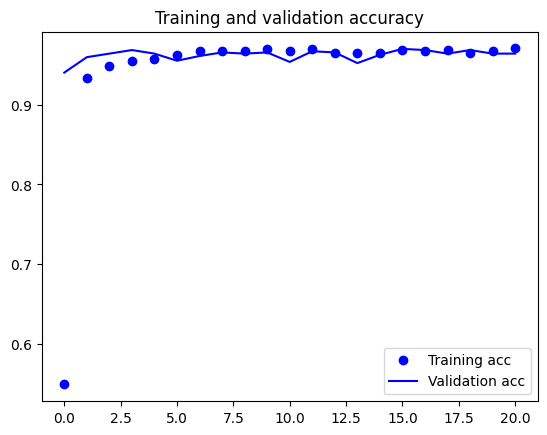

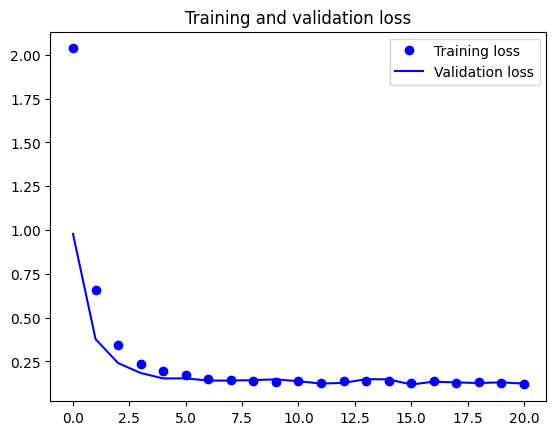

In [ ]:
plot_history_scores( dict_history = history4)

In [ ]:
race_list[1]

'n02085936-Maltese_dog'

In [ ]:
list_images_test,images_test = get_images(race_list[1], 2, 224) # image_size=227
list_images_test

['n02085936_10307.jpg', 'n02085936_10297.jpg']

In [ ]:
prediction_test_image(model4,images_test[0])

1/1 [==============================] - 6s 6s/step


['Maltese_dog']

In [ ]:
prediction_test_image(model4,images_test[1])

1/1 [==============================] - 0s 58ms/step


['Maltese_dog']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model4.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model4 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model4)

27/27 [==============================] - 13s 358ms/step
accuracy of test =  0.9823321554770318


In [ ]:
total_params_4 = model4.count_params()
print('Total parameters:', total_params_4)

Total parameters: 28022132


In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  
df_results = df_results.append({'model': 'ConvNextTiny','learning_rate':lr ,'accuracy_test': acc_score_model4, 'temps': preprocess_time4, 'model_size': total_params_4}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132


## model 5 (mobile net v3)


MobileNetV3 est une architecture de réseau de neurones convolutifs spécialement conçue pour les appareils mobiles et les systèmes embarqués. Il s'agit de la troisième version de la famille de modèles MobileNet, développée par Google. 

MobileNetV3 vise à fournir une architecture légère avec des performances élevées pour les tâches de vision par ordinateur, tout en réduisant l'utilisation des ressources, notamment la puissance de calcul et la mémoire. 

* MobileNetV3 utilise des blocs de construction spécifiques, tels que les blocs "bouteille de cou", qui permettent de réduire le nombre de paramètres et les calculs nécessaires tout en maintenant de bonnes performances.

MobileNetV3 offre des performances compétitives sur diverses tâches de vision par ordinateur, telles que la classification d'images, la détection d'objets et la segmentation sémantique, tout en étant adapté aux contraintes des appareils mobiles et des systèmes embarqués

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small

In [ ]:
# Charger le modèle MobileNetV3 pré-entraîné
model5 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
for layer in model5.layers:
    layer.trainable = False

In [ ]:
# Exemple de couches de classification supplémentaires

xm = tf.keras.layers.GlobalAveragePooling2D()(model5.output)
xm = tf.keras.layers.Dense(256, activation='relu')(xm)
xm = tf.keras.layers.Dropout(0.2)(xm)
predictions = tf.keras.layers.Dense(nbr_classes, activation='softmax')(xm)

# Créez un nouveau modèle en spécifiant les entrées et les sorties
model5 = tf.keras.models.Model(inputs=model5.input, outputs=predictions)

In [ ]:
lr = 1e-4

In [ ]:
# Compiler le modèle
model5.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr),metrics=['accuracy'])

In [ ]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='val_accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  

In [ ]:
# with freezing weights 
start_time5 = timeit.default_timer()
epochs = 30
history5= model5.fit(  train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    validation_data=validation_generator,
    validation_steps = validation_generator.n // batch_size,    
    epochs=epochs,
    callbacks = [lrr,early_stop],
    verbose=1)
preprocess_time5 = timeit.default_timer() - start_time5
print("Total time : {:.2f}s".format(preprocess_time5))

Epoch 1/30
169/169 [==============================] - 56s 259ms/step - loss: 2.4476 - accuracy: 0.2685 - val_loss: 1.7607 - val_accuracy: 0.5491 - lr: 1.0000e-04
Epoch 2/30
169/169 [==============================] - 41s 241ms/step - loss: 1.5964 - accuracy: 0.5259 - val_loss: 1.2649 - val_accuracy: 0.6548 - lr: 1.0000e-04
Epoch 3/30
169/169 [==============================] - 40s 237ms/step - loss: 1.2338 - accuracy: 0.6304 - val_loss: 1.0222 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 4/30
169/169 [==============================] - 40s 237ms/step - loss: 1.0524 - accuracy: 0.6781 - val_loss: 0.8805 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 5/30
169/169 [==============================] - 38s 224ms/step - loss: 0.9127 - accuracy: 0.7319 - val_loss: 0.8388 - val_accuracy: 0.7440 - lr: 1.0000e-04
Epoch 6/30
169/169 [==============================] - 40s 237ms/step - loss: 0.8599 - accuracy: 0.7315 - val_loss: 0.8213 - val_accuracy: 0.7455 - lr: 1.0000e-04
Epoch 7/30
169/169 [========

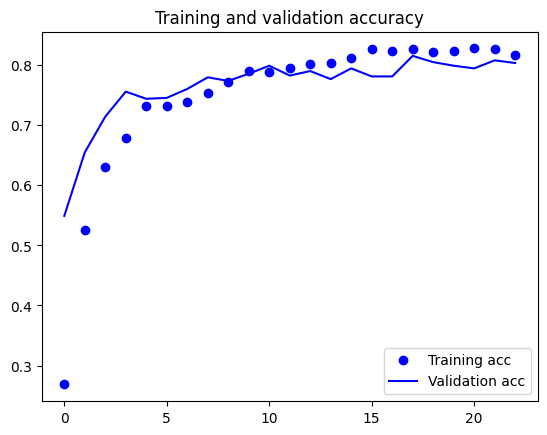

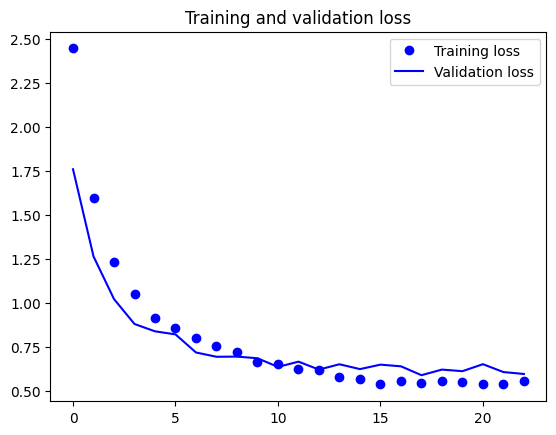

In [ ]:
plot_history_scores( dict_history = history5)

In [ ]:
race_list[1]

'n02085936-Maltese_dog'

In [ ]:
list_images_test,images_test = get_images(race_list[1], 2, 224) # image_size=227
list_images_test

['n02085936_10307.jpg', 'n02085936_10297.jpg']

In [ ]:
prediction_test_image(model5,images_test[0])

1/1 [==============================] - 1s 1s/step


['Maltese_dog']

In [ ]:
prediction_test_image(model5,images_test[1])

1/1 [==============================] - 0s 28ms/step


['Maltese_dog']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model5.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model5 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model5)

27/27 [==============================] - 1s 23ms/step
accuracy of test =  0.8716136631330977


In [ ]:
total_params_5 = model5.count_params()
print('Total parameters:', total_params_5)

Total parameters: 1091972


In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  
df_results = df_results.append({'model': 'MobilNetV3','learning_rate':lr, 'accuracy_test': acc_score_model5, 'temps': preprocess_time5, 'model_size': total_params_5}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132
2,MobilNetV3,0.0001,0.871614,985.952251,1091972


## Varier le learning rate pour le modèle choisi

D'après les résultats, le modèle ConvNextTiny est celui qui obtient le score d'accuracy le plus élevé avec 0.98. Cependant, il nécessite également le plus de temps de calcul et un plus grand nombre de paramètres. D'autre part, le modèle EfficientNetV2B0 est également performant avec une accuracy de 0.96, mais il nécessite moins de paramètres et moins de temps. Pour cette raison, nous avons choisi de poursuivre le reste de notre travail avec le modèle EfficientNetV2B0.

Maintenant, nous allons varier le learning rate pour le modèle choisi, afin d'étudier l'impact de cet hyperparamètre sur l'accuracy et le temps d'exécution.

dans le modèle choisi le learning rate était de 1e-4 , nous allons tester les valeurs suivante pour ce param: learning rate = 1e-3 , 1e-2. 

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# importation du modèle  EfficientNetV2B0 pré-entrainer
efficient_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Gel des poids du modèle pré-entraîné pour éviter qu'ils ne soient mis à jour lors de l'entraînement
efficient_model.trainable = False
xef = GlobalAveragePooling2D()(efficient_model.output)
xef = Dense(256, activation='relu')(xef)
xef = tf.keras.layers.Dropout(0.2)(xef)
output = Dense(nbr_classes, activation='softmax')(xef)  

24274472/24274472 [==============================] - 2s 0us/step


### learning rate = 1e-3

Epoch 1/30
169/169 [==============================] - 58s 255ms/step - loss: 0.5956 - accuracy: 0.8274 - val_loss: 0.2230 - val_accuracy: 0.9182 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 42s 245ms/step - loss: 0.2746 - accuracy: 0.9037 - val_loss: 0.2209 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 41s 244ms/step - loss: 0.2447 - accuracy: 0.9204 - val_loss: 0.2370 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 41s 243ms/step - loss: 0.2006 - accuracy: 0.9293 - val_loss: 0.2714 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 41s 243ms/step - loss: 0.1816 - accuracy: 0.9352 - val_loss: 0.2758 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 41s 241ms/step - loss: 0.1482 - accuracy: 0.9522 - val_loss: 0.2865 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

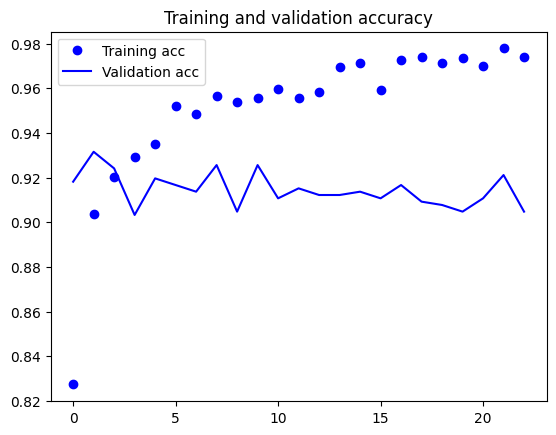

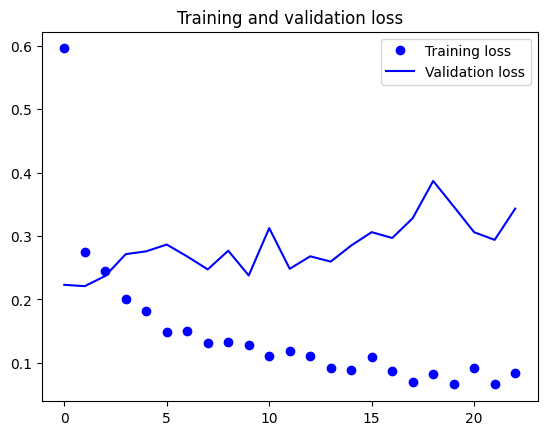

27/27 [==============================] - 5s 69ms/step


NameError: ignored

In [ ]:
model3_lr1e3 = Model(inputs=efficient_model.input, outputs=output)
lr = 1e-3
model3_lr1e3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=3 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs = 30 
# traning without data augmentation and trainable = True
start_time3_1e3 = timeit.default_timer()
history3_1e3 = model3_lr1e3.fit(train_generator,
                                steps_per_epoch= train_generator.n // batch_size,
                                validation_data=validation_generator,
                                validation_steps = validation_generator.n // batch_size,    
                                epochs=epochs,
                                callbacks = [lrr,early_stop],
                                verbose=1)
preprocess_time3_1e3 = timeit.default_timer() - start_time3_1e3
print("Total time : {:.2f}s".format(preprocess_time3_1e3))
plot_history_scores( dict_history = history3_1e3)
y_pred = model3_lr1e3.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score
acc_score_model3_lr1e3 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model3_lr1e3)
total_params_3_1e3 = model3_lr1e3.count_params()
print('Total parameters:', total_params_3_1e3)

accuracy of test =  0.9634864546525324
Total parameters: 6252388


In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  

df_results = df_results.append({'model': 'efficientnetV2B0','learning_rate':lr, 'accuracy_test': acc_score_model3_lr1e3, 'temps': preprocess_time3_1e3, 'model_size': total_params_3_1e3}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132
2,MobilNetV3,0.0001,0.871614,985.952251,1091972
3,efficientnetV2B0,0.0010,0.963486,1403.241162,6252388


### learning rate = 1e-2

In [ ]:
from sklearn.metrics import accuracy_score

Epoch 1/30
169/169 [==============================] - 79s 377ms/step - loss: 0.8477 - accuracy: 0.7993 - val_loss: 0.5255 - val_accuracy: 0.8810 - lr: 0.0100
Epoch 2/30
169/169 [==============================] - 48s 286ms/step - loss: 0.6362 - accuracy: 0.8470 - val_loss: 0.3728 - val_accuracy: 0.9018 - lr: 0.0100
Epoch 3/30
169/169 [==============================] - 44s 260ms/step - loss: 0.6224 - accuracy: 0.8622 - val_loss: 0.4788 - val_accuracy: 0.8943 - lr: 0.0100
Epoch 4/30
169/169 [==============================] - 46s 271ms/step - loss: 0.6097 - accuracy: 0.8689 - val_loss: 0.7014 - val_accuracy: 0.8780 - lr: 0.0100
Epoch 5/30
169/169 [==============================] - 42s 250ms/step - loss: 0.5998 - accuracy: 0.8778 - val_loss: 0.6640 - val_accuracy: 0.8765 - lr: 0.0100
Epoch 6/30
169/169 [==============================] - 52s 309ms/step - loss: 0.4937 - accuracy: 0.8859 - val_loss: 0.6044 - val_accuracy: 0.8824 - lr: 0.0100
Epoch 7/30
169/169 [==============================] 

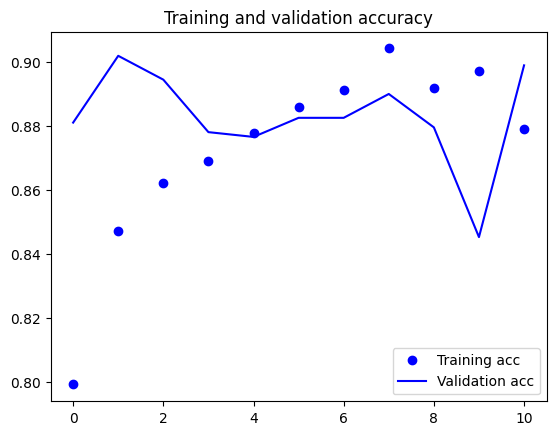

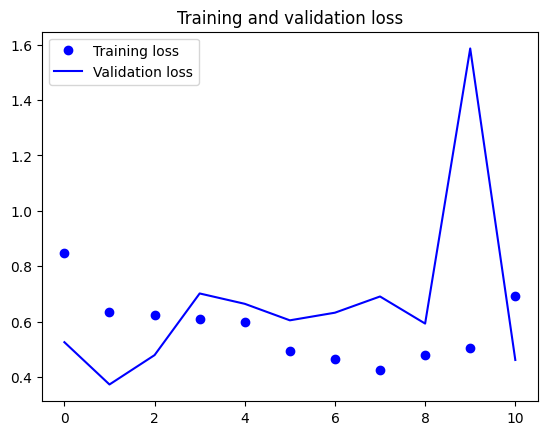

27/27 [==============================] - 5s 77ms/step
accuracy of test =  0.9575971731448764
Total parameters: 6252388


In [ ]:
model3_lr1e2 = Model(inputs=efficient_model.input, outputs=output)
lr = 1e-2
model3_lr1e2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=3 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs = 30 
# traning without data augmentation and trainable = True
start_time3_1e2 = timeit.default_timer()
history3_1e2 = model3_lr1e2.fit(train_generator,
                                steps_per_epoch= train_generator.n // batch_size,
                                validation_data=validation_generator,
                                validation_steps = validation_generator.n // batch_size,    
                                epochs=epochs,
                                callbacks = [lrr,early_stop],
                                verbose=1)
preprocess_time3_1e2 = timeit.default_timer() - start_time3_1e2
print("Total time : {:.2f}s".format(preprocess_time3_1e2))
plot_history_scores( dict_history = history3_1e2)
y_pred = model3_lr1e2.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
acc_score_model3_1e2 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model3_1e2)
total_params_3_1e2 = model3_lr1e2.count_params()
print('Total parameters:', total_params_3_1e2)


In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  

df_results = df_results.append({'model': 'efficientnetV2B0','learning_rate':lr, 'accuracy_test': acc_score_model3_1e2, 'temps': preprocess_time3_1e2, 'model_size': total_params_3_1e2}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)
df_results

,model,learning_rate,accuracy_test,temps,model_size
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132
2,MobilNetV3,0.0001,0.871614,985.952251,1091972
3,efficientnetV2B0,0.0010,0.963486,1403.241162,6252388
4,efficientnetV2B0,0.0100,0.957597,725.197869,6252388


suivant le tableau des résultas pour le modèle "EfficientNetV2B0" et suivant les courbe d'apprentissage(loss et accuracy), nous remarquons , que plus le learning rate est grande, plus les résultas de la validation sont perturbé et ne suivent pas la courbe de training.  malgré  que le score d'accuracy_test est bon (0.95 pour learning rate = 1e-2) mais la courbe d'apprentissage ne montre pas un très bon apprentissage.  dans notre cas le meilleur learning rate suivant les résultats et les courbes d'apprentissage est = 1e-4. 


Pour la suite de ce travail : on va utiliser learning rate = 1e-4.

In [ ]:
df_results['batchsize'] = [16,16,16,16,16]

In [ ]:
df_results

,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388,16
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132,16
2,MobilNetV3,0.0001,0.871614,985.952251,1091972,16
3,efficientnetV2B0,0.0010,0.963486,1403.241162,6252388,16
4,efficientnetV2B0,0.0100,0.957597,725.197869,6252388,16


In [ ]:
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)

## Varier le Batchsize

Maintenant, nous allons varier le Batchsize pour le modèle choisi, afin d'étudier l'impact de cet hyperparamètre sur l'accuracy et le temps d'exécution.

Nous les résultas précedent sont obtenue avec Batchsize = 16, maintenent on va tester Batchsize=8. 

### Batchsize = 8

In [ ]:
batch_size = 8

# Validation set is define here
train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2, #set valisation split
                                   preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
                                    )

#For test just rescale
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, subset='training')
validation_generator = train_datagen.flow( x_train, y_train, batch_size = batch_size,  subset='validation')

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# importation du modèle  EfficientNetV2B0 pré-entrainer
efficient_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Gel des poids du modèle pré-entraîné pour éviter qu'ils ne soient mis à jour lors de l'entraînement
efficient_model.trainable = False
xef = GlobalAveragePooling2D()(efficient_model.output)
xef = Dense(256, activation='relu')(xef)
xef = tf.keras.layers.Dropout(0.2)(xef)
output = Dense(nbr_classes, activation='softmax')(xef)  

24274472/24274472 [==============================] - 0s 0us/step


Epoch 1/30
339/339 [==============================] - 68s 150ms/step - loss: 1.5464 - accuracy: 0.6846 - val_loss: 0.5973 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 2/30
339/339 [==============================] - 54s 159ms/step - loss: 0.4708 - accuracy: 0.8885 - val_loss: 0.3393 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 3/30
339/339 [==============================] - 45s 131ms/step - loss: 0.3267 - accuracy: 0.9092 - val_loss: 0.2981 - val_accuracy: 0.9048 - lr: 1.0000e-04
Epoch 4/30
339/339 [==============================] - 42s 125ms/step - loss: 0.2731 - accuracy: 0.9177 - val_loss: 0.2552 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 5/30
339/339 [==============================] - 43s 128ms/step - loss: 0.2360 - accuracy: 0.9276 - val_loss: 0.2704 - val_accuracy: 0.9137 - lr: 1.0000e-04
Epoch 6/30
339/339 [==============================] - 40s 118ms/step - loss: 0.2204 - accuracy: 0.9306 - val_loss: 0.2503 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 7/30
339/339 [========

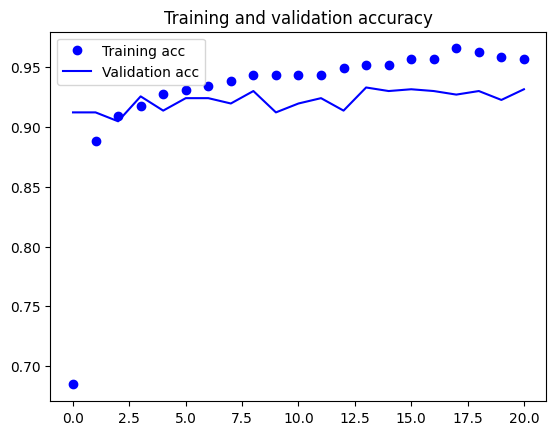

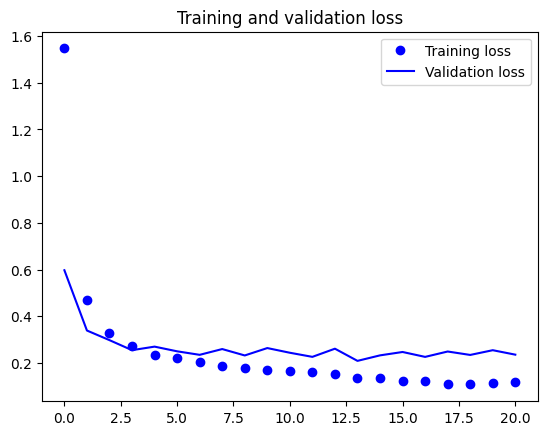

27/27 [==============================] - 4s 74ms/step


NameError: ignored

In [ ]:
model3_btch8 = Model(inputs=efficient_model.input, outputs=output)
lr = 1e-4
model3_btch8.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=3 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs = 30 
# traning without data augmentation and trainable = True
start_time3_btch8 = timeit.default_timer()
history3_btch8 = model3_btch8.fit(train_generator,
                                steps_per_epoch= train_generator.n // batch_size,
                                validation_data=validation_generator,
                                validation_steps = validation_generator.n // batch_size,    
                                epochs=epochs,
                                callbacks = [lrr,early_stop],
                                verbose=1)
preprocess_time3_btch8 = timeit.default_timer() - start_time3_btch8
print("Total time : {:.2f}s".format(preprocess_time3_btch8))
plot_history_scores( dict_history = history3_btch8)
y_pred = model3_btch8.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_score_model3_btch8 = accuracy_score(y_test,y_pred)
print("accuracy of test = ", acc_score_model3_btch8)
total_params_3_btch8 = model3_btch8.count_params()
print('Total parameters:', total_params_3_btch8)

accuracy of test =  0.9658421672555948
Total parameters: 6252388


In [ ]:
df_results = pd.read_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv')  

df_results = df_results.append({'model': 'efficientnetV2B0','learning_rate':lr, 'accuracy_test': acc_score_model3_btch8, 'temps': preprocess_time3_btch8,
                                'model_size': total_params_3_btch8,'batchsize':batch_size}, ignore_index=True)
df_results.to_csv('/content/drive/MyDrive/Openclassrooms/resultas.csv', index=False)
df_results

<ipython-input-29-522b40023fab>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'model': 'efficientnetV2B0','learning_rate':lr, 'accuracy_test': acc_score_model3_btch8, 'temps': preprocess_time3_btch8,


,model,learning_rate,accuracy_test,temps,model_size,batchsize
0,efficientnetV2B0,0.0001,0.963486,925.396086,6252388,16
1,ConvNextTiny,0.0001,0.982332,1467.736406,28022132,16
2,MobilNetV3,0.0001,0.871614,985.952251,1091972,16
3,efficientnetV2B0,0.0010,0.963486,1403.241162,6252388,16
4,efficientnetV2B0,0.0100,0.957597,725.197869,6252388,16
5,efficientnetV2B0,0.0001,0.965842,1210.955557,6252388,8


le meilleur modèle en fonction d'accuracy , temps et model_size est 
efficientNetV2B0 avec learning rate = 1e-4 et batchsize = 16

# L'apprentissage sur le dataset complet

pour alléger la mémoire RAM , nous allons charger par batch les images grace à la fonction : **flow_from_dicrectory**. 

In [ ]:
images_dir

'/content/drive/MyDrive/Openclassrooms/Images_'

In [ ]:
#create teh date set
image_size = (224, 224)
batch_size = 16

In [ ]:
#!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import splitfolders
#splitfolders.ratio(images_dir, output="/content/drive/MyDrive/Openclassrooms/output1", seed=1337, ratio=(0.8,0.2)) 

Copying files: 20580 files [19:24, 17.68 files/s] 


In [ ]:
src_path_train ='/content/drive/MyDrive/Openclassrooms/output/train'
src_path_test = '/content/drive/MyDrive/Openclassrooms/output/val'


In [ ]:
train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2, #set valisation split
                                   preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
                                    )
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)


test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size = image_size,
    color_mode="rgb",
    batch_size=batch_size,

    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,

    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=image_size,
    color_mode="rgb",

    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 13172 images belonging to 120 classes.
Found 3246 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [ ]:
K.clear_session()

In [ ]:
nbr_classes= 120

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# importation du modèle  EfficientNetV2B0 pré-entrainer
efficient_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Gel des poids du modèle pré-entraîné pour éviter qu'ils ne soient mis à jour lors de l'entraînement
efficient_model.trainable = False
xef = GlobalAveragePooling2D()(efficient_model.output)
xef = Dense(256, activation='relu')(xef)
xef = tf.keras.layers.Dropout(0.2)(xef)
output = Dense(nbr_classes, activation='softmax')(xef)  

In [ ]:
model3_final = Model(inputs=efficient_model.input, outputs=output)
lr = 1e-4
model3_final.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=3 , mode='min') # This callback will stop the training when there is no improvement in the loss for three consecutive epochs
lrr = ReduceLROnPlateau( monitor='accuracy',  factor=.01 ,  patience = 3 , min_lr=1e-5 , verbose=1)  
epochs = 30 
# traning without data augmentation and trainable = True
start_time3 = timeit.default_timer()
history3 = model3_final.fit(train_generator,
                                steps_per_epoch= train_generator.n // train_generator.batch_size,
                                validation_data=valid_generator,
                                validation_steps = valid_generator.n // train_generator.batch_size,    
                                epochs=epochs,
                                callbacks = [lrr,early_stop],
                                verbose=1)
preprocess_time3 = timeit.default_timer() - start_time3
print("Total time : {:.2f}s".format(preprocess_time3))



Epoch 1/30
823/823 [==============================] - 241s 284ms/step - loss: 3.2731 - accuracy: 0.3901 - val_loss: 1.6852 - val_accuracy: 0.7141 - lr: 1.0000e-04
Epoch 2/30
823/823 [==============================] - 230s 279ms/step - loss: 1.3560 - accuracy: 0.6846 - val_loss: 0.9566 - val_accuracy: 0.7655 - lr: 1.0000e-04
Epoch 3/30
823/823 [==============================] - 226s 274ms/step - loss: 1.0168 - accuracy: 0.7197 - val_loss: 0.8069 - val_accuracy: 0.7791 - lr: 1.0000e-04
Epoch 4/30
823/823 [==============================] - 228s 277ms/step - loss: 0.8820 - accuracy: 0.7485 - val_loss: 0.7398 - val_accuracy: 0.7927 - lr: 1.0000e-04
Epoch 5/30
823/823 [==============================] - 228s 277ms/step - loss: 0.8183 - accuracy: 0.7567 - val_loss: 0.7105 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 6/30
823/823 [==============================] - 226s 275ms/step - loss: 0.7608 - accuracy: 0.7726 - val_loss: 0.7032 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 7/30
823/823 [==

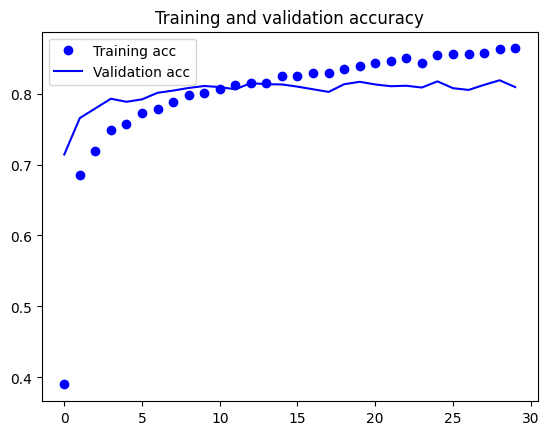

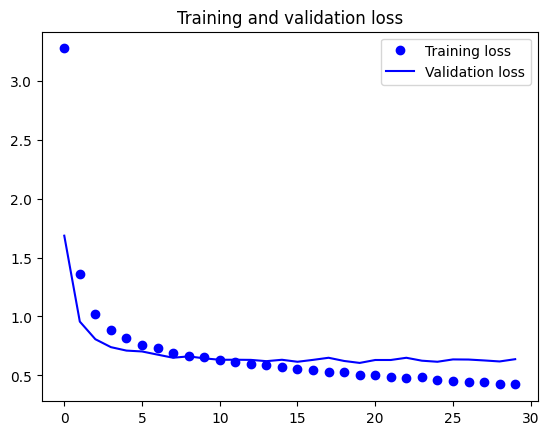

In [ ]:
plot_history_scores( dict_history = history3)

In [ ]:
score = model3_final.evaluate_generator(valid_generator)
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.6283208727836609
val accuracy: 0.8163893818855286


In [ ]:
score_test = model3_final.evaluate(test_generator)
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

261/261 [==============================] - 21s 81ms/step - loss: 0.4329 - accuracy: 0.8667
Test loss: 0.4328947067260742
Test accuracy: 0.8666506409645081


reload ici 

In [ ]:
predict=model3_final.predict(test_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)

261/261 [==============================] - 1875s 7s/step


In [ ]:
y_classes

array([  0,   0,   7, ..., 119, 119, 119])

In [ ]:
len(y_classes)

4162

In [ ]:
y_true = test_generator.classes

In [ ]:
y_true

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [ ]:
predict

array([[9.80400443e-01, 1.09445382e-05, 3.62962510e-06, ...,
        1.72582058e-05, 5.57400017e-06, 7.20770913e-06],
       [9.92786348e-01, 1.11624558e-07, 1.77525635e-05, ...,
        2.40396723e-04, 9.40894608e-07, 1.76754966e-05],
       [7.36372992e-02, 5.08469043e-07, 3.42630733e-06, ...,
        6.10083771e-05, 9.08221045e-06, 1.02643424e-03],
       ...,
       [2.85629212e-04, 6.80331459e-06, 1.21191944e-04, ...,
        2.88337772e-03, 1.42362202e-03, 8.22951972e-01],
       [4.58279419e-06, 4.01839088e-07, 4.08919846e-07, ...,
        4.83040967e-05, 3.36968442e-05, 9.99512553e-01],
       [7.45618581e-06, 4.87061527e-07, 3.59849111e-07, ...,
        1.91458294e-05, 2.87280836e-05, 9.99716341e-01]], dtype=float32)

In [ ]:
 import numpy
 y_pred = numpy.rint(predict)
 y_pred

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
len(y_pred)

4162

In [ ]:
y_pred

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix

array([[22,  0,  0, ...,  0,  0,  0],
       [ 2, 32,  0, ...,  0,  0,  0],
       [ 2,  0, 47, ...,  0,  0,  0],
       ...,
       [ 4,  0,  0, ..., 25,  1,  0],
       [ 1,  0,  0, ...,  0, 27,  1],
       [ 1,  0,  0, ...,  0,  0, 33]])

In [ ]:
# Calcul de l'accuracy par classe
class_acc = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

In [ ]:
#récupérer les noms des classes
class_names = [name.split('-')[1] for name in race_list]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

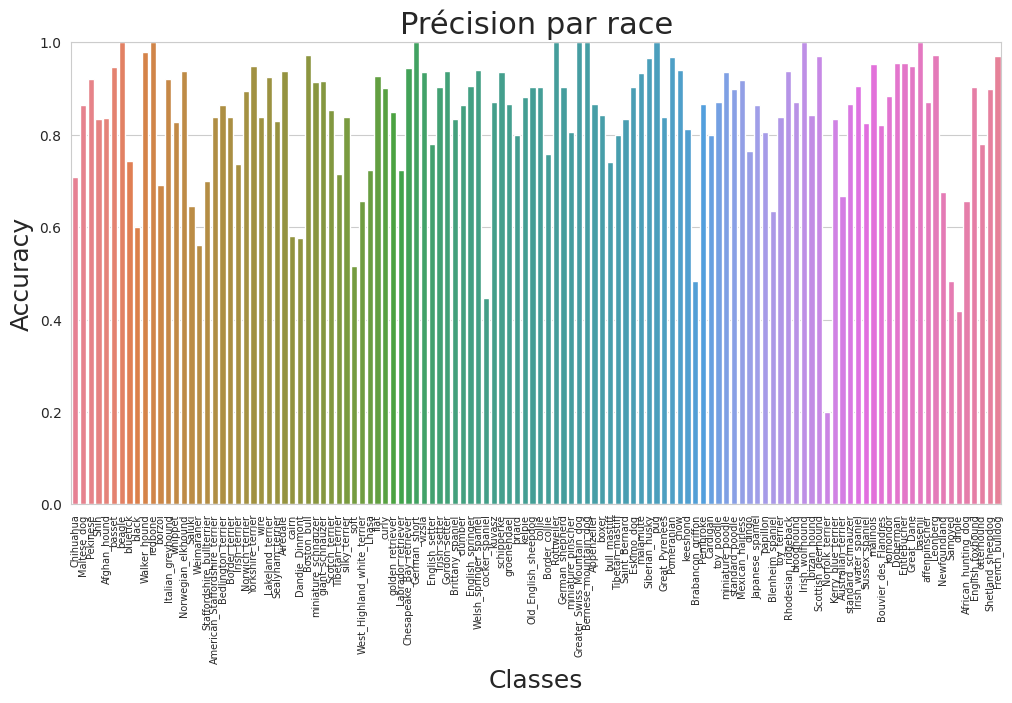

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_names, y=class_acc, palette='husl')
ax.set_xticklabels(class_names, rotation=90, size=7)
ax.set_ylim([0, 1])
ax.set_title('Précision par race', size = 22)
ax.set_xlabel("Classes", size= 18)
ax.set_ylabel("Accuracy", size= 18)
plt.show()

In [ ]:
# Create a pandas dataframe to store the accuracy for each class
accuracy_df = pd.DataFrame({'race': class_names, 'Accuracy': class_acc})

# Sort the dataframe by accuracy in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)


top_10_races = accuracy_df.head(10)
worst_10_races = accuracy_df.tail(10)

def plot_breeds(data, title):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(data['race'], data['Accuracy'])
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.show()

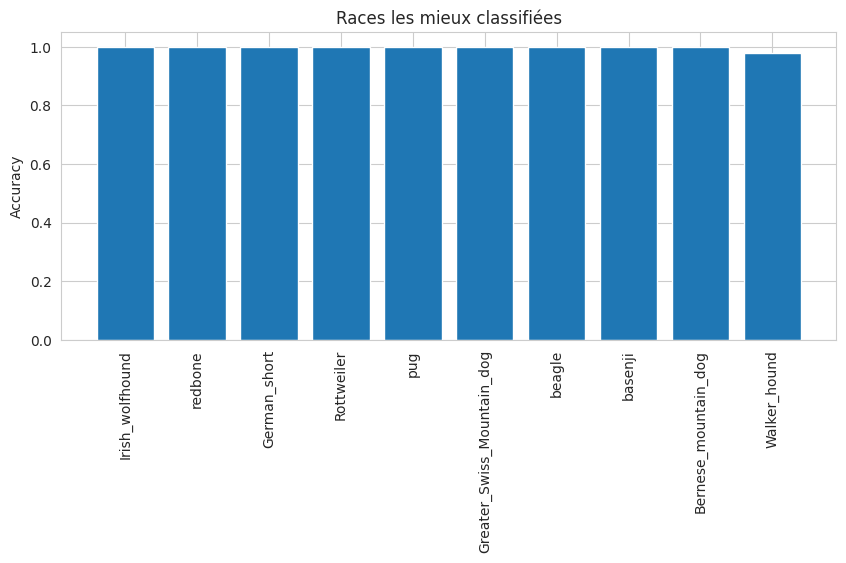

In [ ]:
plot_breeds(top_10_races, 'Races les mieux classifiées')

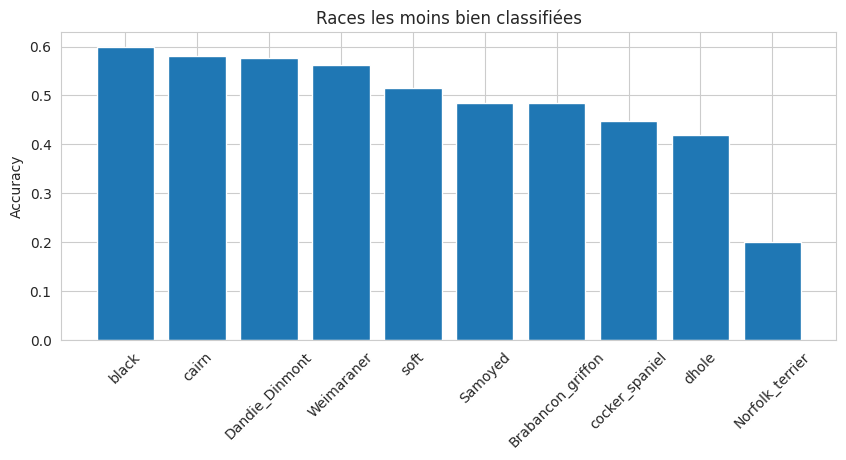

In [ ]:
plot_breeds(worst_10_races, 'Races les moins bien classifiées')

In [ ]:

misclassified_indices = np.where(np.array(y_true) != np.array(y_pred))

misclassified_true_labels = np.array(y_true)[misclassified_indices]
misclassified_predicted_labels = np.array(y_pred)[misclassified_indices]

misclassified_breeds = pd.DataFrame({'True Label': misclassified_true_labels, 'Predicted Label': misclassified_predicted_labels})
misclassification_counts = misclassified_breeds.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')

misclassification_counts = misclassification_counts.sort_values(by='Count', ascending=False)

num_misclassifications_to_display = 10
top_misclassifications = misclassification_counts.head(num_misclassifications_to_display)

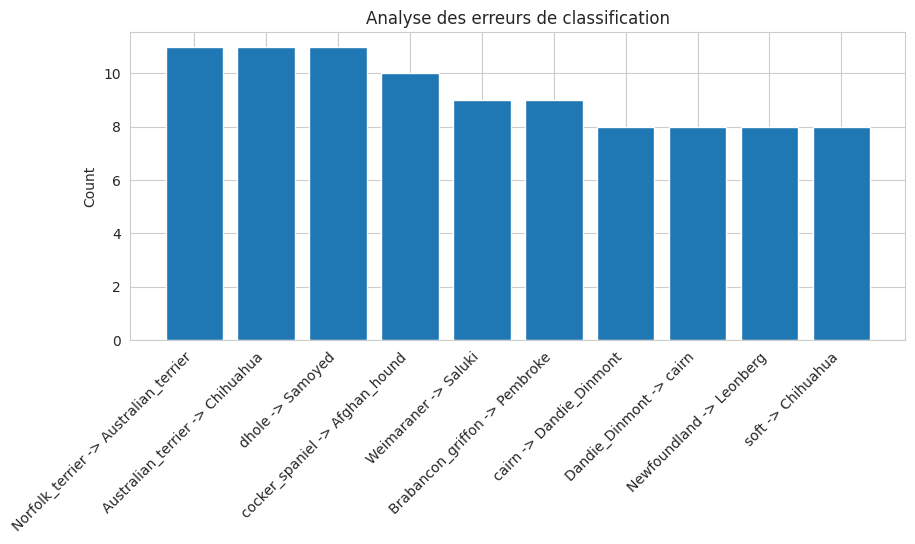

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(num_misclassifications_to_display), top_misclassifications['Count'])
ax.set_xticks(range(num_misclassifications_to_display))
ax.set_xticklabels([f"{class_names[int(row['True Label'])]} -> {class_names[int(row['Predicted Label'])]}" for _, row in top_misclassifications.iterrows()], rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Analyse des erreurs de classification')
plt.show()

In [ ]:
model3_final.save('/content/drive/MyDrive/Openclassrooms/model_classification_race_chien_v2.h5') 

In [ ]:
model3_final = tf.keras.models.load_model('/content/drive/MyDrive/Openclassrooms/model_classification_race_chien_v2.h5')

In [ ]:
list_race = train_generator.class_indices

In [ ]:
list_race

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [ ]:
output =  {k.split('-')[1] :v  for k , v in list_race.items()}


In [ ]:
output

{'Chihuahua': 0,
 'Japanese_spaniel': 1,
 'Maltese_dog': 2,
 'Pekinese': 3,
 'Shih': 4,
 'Blenheim_spaniel': 5,
 'papillon': 6,
 'toy_terrier': 7,
 'Rhodesian_ridgeback': 8,
 'Afghan_hound': 9,
 'basset': 10,
 'beagle': 11,
 'bloodhound': 12,
 'bluetick': 13,
 'black': 14,
 'Walker_hound': 15,
 'English_foxhound': 16,
 'redbone': 17,
 'borzoi': 18,
 'Irish_wolfhound': 19,
 'Italian_greyhound': 20,
 'whippet': 21,
 'Ibizan_hound': 22,
 'Norwegian_elkhound': 23,
 'otterhound': 24,
 'Saluki': 25,
 'Scottish_deerhound': 26,
 'Weimaraner': 27,
 'Staffordshire_bullterrier': 28,
 'American_Staffordshire_terrier': 29,
 'Bedlington_terrier': 30,
 'Border_terrier': 31,
 'Kerry_blue_terrier': 32,
 'Irish_terrier': 33,
 'Norfolk_terrier': 34,
 'Norwich_terrier': 35,
 'Yorkshire_terrier': 36,
 'wire': 37,
 'Lakeland_terrier': 38,
 'Sealyham_terrier': 39,
 'Airedale': 40,
 'cairn': 41,
 'Australian_terrier': 42,
 'Dandie_Dinmont': 43,
 'Boston_bull': 44,
 'miniature_schnauzer': 45,
 'giant_schnauzer

In [ ]:
output = {v: k for k, v in output.items()}

In [ ]:
output

{0: 'Chihuahua',
 1: 'Japanese_spaniel',
 2: 'Maltese_dog',
 3: 'Pekinese',
 4: 'Shih',
 5: 'Blenheim_spaniel',
 6: 'papillon',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound',
 10: 'basset',
 11: 'beagle',
 12: 'bloodhound',
 13: 'bluetick',
 14: 'black',
 15: 'Walker_hound',
 16: 'English_foxhound',
 17: 'redbone',
 18: 'borzoi',
 19: 'Irish_wolfhound',
 20: 'Italian_greyhound',
 21: 'whippet',
 22: 'Ibizan_hound',
 23: 'Norwegian_elkhound',
 24: 'otterhound',
 25: 'Saluki',
 26: 'Scottish_deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_bullterrier',
 29: 'American_Staffordshire_terrier',
 30: 'Bedlington_terrier',
 31: 'Border_terrier',
 32: 'Kerry_blue_terrier',
 33: 'Irish_terrier',
 34: 'Norfolk_terrier',
 35: 'Norwich_terrier',
 36: 'Yorkshire_terrier',
 37: 'wire',
 38: 'Lakeland_terrier',
 39: 'Sealyham_terrier',
 40: 'Airedale',
 41: 'cairn',
 42: 'Australian_terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_bull',
 45: 'miniature_schnauzer',
 46: 'giant_schna

In [ ]:
import json 
json_object = json.dumps(output, indent = 4) 

In [ ]:
# Using a JSON string
with open('/content/drive/MyDrive/Openclassrooms/list_race_name.json', 'w') as outfile:
    outfile.write(json_object)